In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1233)
tf.random.set_seed(1233)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

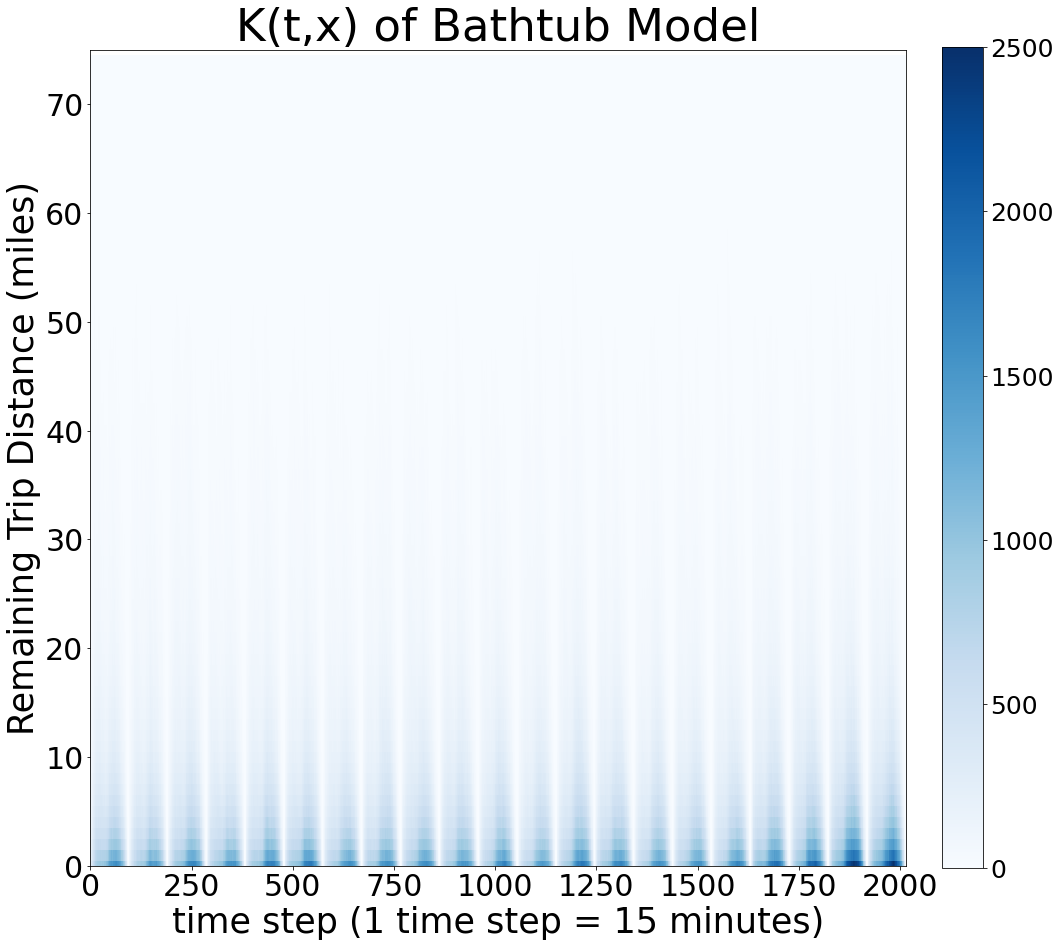

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 3 # unit: miles
size_input = int(N_diststep/Size_diststep)*N_timestep # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  50400
N_u =  10080
N_f =  20160


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1233)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(10080, 2)

In [12]:
X_u_test.shape

(40320, 2)

In [13]:
X_u_train

array([[0.72972973, 0.75980149],
       [0.36486486, 0.27890819],
       [0.72972973, 0.93002481],
       ...,
       [0.32432432, 0.30918114],
       [0.2027027 , 0.23622829],
       [0.44594595, 0.30719603]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u
    
    def loss(self,x,y):

        loss_u = self.loss_BC(x,y)

        loss = loss_u

        return loss, loss_u
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u= self.loss(X_u_train, u_train)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u = self.loss(X_u_train, u_train)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        
        tf.print(loss_value, loss_u, error_vec)

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [15]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.00881934454617372 0.00881934454617372 0.8433408678469333
0.0083962662300983842 0.0083962662300983842 0.8220620259293899
0.00731137795254949 0.00731137795254949 0.7641518327674973
0.0070400266490612236 0.0070400266490612236 0.749008020652701
0.0070273000612159509 0.0070273000612159509 0.7483719417476145
0.0070258278430541526 0.0070258278430541526 0.7483547741170855
0.0070212400742672891 0.0070212400742672891 0.7483030962045251
0.0070150414035914819 0.0070150414035914819 0.7481999005001372
0.0070063627795955152 0.0070063627795955152 0.7479279709605401
0.0069972047826812262 0.0069972047826812262 0.7475069964167677
0.0069867946706294575 0.0069867946706294575 0.7468925090148086
0.0069732614341570928 0.0069732614341570928 0.7460090609049851
0.0069376929797497064 0.0069376929797497064 0.7437251646726005
0.0068446135482361 0.0068446135482361 0.7380440362952249
0.0066674940763473073 0.0066674940763473073 0.7274324257306868
0.0063078995280796994 0.0063078995280796994 0.7076219614971376
0.00601

0.0023583050401620414 0.0023583050401620414 0.436818944286412
0.0023579067873221757 0.0023579067873221757 0.4367875335901477
0.002357720338863199 0.002357720338863199 0.43675636400437867
0.002357112970879034 0.002357112970879034 0.43668478976471276
0.0023563139731589975 0.0023563139731589975 0.43662575350666766
0.0023557594481366808 0.0023557594481366808 0.43654040389389076
0.0023553985824920189 0.0023553985824920189 0.4364807439063797
0.0023545089385534194 0.0023545089385534194 0.4363555978852341
0.0023542029609778924 0.0023542029609778924 0.43633684245324067
0.0023539843274595924 0.0023539843274595924 0.436286195985345
0.0023539260517194916 0.0023539260517194916 0.4363068860244536
0.0023537523302034949 0.0023537523302034949 0.43628860397672736
0.0023536371041420067 0.0023536371041420067 0.43625059630505136
0.0023534554063468749 0.0023534554063468749 0.43620400462026887
0.0023530813795934326 0.0023530813795934326 0.43613313590273206
0.0023524609569036434 0.0023524609569036434 0.436025

0.0022988153078967273 0.0022988153078967273 0.4315395387977331
0.0022987375030326714 0.0022987375030326714 0.4315380616399664
0.0022986868795942558 0.0022986868795942558 0.43154488053128953
0.0022985962375228976 0.0022985962375228976 0.4315647820440739
0.002298534492267097 0.002298534492267097 0.43155303935588873
0.0022984852142276346 0.0022984852142276346 0.43151706500822606
0.0022984555202823259 0.0022984555202823259 0.43151621170318993
0.0022984180876216274 0.0022984180876216274 0.4315192014867484
0.0022983835792664592 0.0022983835792664592 0.4315079067435728
0.00229834870407725 0.00229834870407725 0.43149358832464146
0.002298329984962791 0.002298329984962791 0.43149189249081116
0.0022983187935784891 0.0022983187935784891 0.43148939152975074
0.0022983167889820415 0.0022983167889820415 0.4314950592318442
0.0022983109483213351 0.0022983109483213351 0.4314882954845917
0.002298309370686551 0.002298309370686551 0.4314918866274292
0.0022983073924738038 0.0022983073924738038 0.431493078722

0.0022877651631304139 0.0022877651631304139 0.43087671464465954
0.0022876805424751853 0.0022876805424751853 0.4308743399149682
0.0022875981128060818 0.0022875981128060818 0.4308775627341064
0.002287559726118786 0.002287559726118786 0.4308754947668099
0.0022875062027456513 0.0022875062027456513 0.4308547613958354
0.0022874730968663673 0.0022874730968663673 0.43085416080406286
0.0022874261825466839 0.0022874261825466839 0.4308567628999796
0.0022873035859404867 0.0022873035859404867 0.4308624412890904
0.0022872758429921848 0.0022872758429921848 0.43085981412915236
0.0022872291154036484 0.0022872291154036484 0.4308412265691771
0.0022871418493557237 0.0022871418493557237 0.4308546245902815
0.0022871230860737695 0.0022871230860737695 0.4308539309983768
0.0022870954089724053 0.0022870954089724053 0.4308417639371924
0.0022870589455885972 0.0022870589455885972 0.4308534992671737
0.002287014265343217 0.002287014265343217 0.43085395681618405
0.0022869641131347883 0.0022869641131347883 0.430840134

0.0022538921150446162 0.0022538921150446162 0.4304312693052205
0.0022536932328962212 0.0022536932328962212 0.43054155317175324
0.0022536836753930547 0.0022536836753930547 0.4306068510559874
0.0022536358949434014 0.0022536358949434014 0.4306587221063241
0.0022536235306466717 0.0022536235306466717 0.43060908154392324
0.0022535987499422852 0.0022535987499422852 0.4306025951582097
0.0022535124974296088 0.0022535124974296088 0.4306194979086912
0.0022534310417818564 0.0022534310417818564 0.43059570896370086
0.0022532714823123834 0.0022532714823123834 0.43054337508759255
0.0022531328024226033 0.0022531328024226033 0.43060945781552773
0.0022528526277347826 0.0022528526277347826 0.43053768043594276
0.0022526508658168181 0.0022526508658168181 0.4305914131134888
0.0022524818554603993 0.0022524818554603993 0.43065180414823656
0.0022521893049604774 0.0022521893049604774 0.4308532931162802
0.0022520697863926483 0.0022520697863926483 0.4308860009646375
0.0022518478133795273 0.0022518478133795273 0.43

0.00221262868049548 0.00221262868049548 0.4418860524595133
0.0022124008357653413 0.0022124008357653413 0.4416270471621486
0.002212361586876572 0.002212361586876572 0.441522895213191
0.0022123248660658864 0.0022123248660658864 0.44158157462335856
0.0022122868636945247 0.0022122868636945247 0.4418347781585779
0.0022122749223004862 0.0022122749223004862 0.4418236174157179
0.0022122619993888829 0.0022122619993888829 0.4417753616709845
0.0022122404464320062 0.0022122404464320062 0.44181827884235736
0.0022122168059020451 0.0022122168059020451 0.4419069044533508
0.002212200552437264 0.002212200552437264 0.4419982378196659
0.0022121873453063864 0.0022121873453063864 0.44202586192565696
0.002212162265509882 0.002212162265509882 0.4421043373947118
0.0022121400930530627 0.0022121400930530627 0.44213721747221274
0.0022121167994938909 0.0022121167994938909 0.442213011876476
0.0022120918765091051 0.0022120918765091051 0.4422841755228523
0.0022120456953658276 0.0022120456953658276 0.44241794382390875

0.0021965508006399296 0.0021965508006399296 0.4451266967944256
0.00219653044437823 0.00219653044437823 0.44513716376851153
0.0021964914151066423 0.0021964914151066423 0.4451962834853234
0.0021964676157702036 0.0021964676157702036 0.4452825852700561
0.0021964405230927653 0.0021964405230927653 0.4450881629428429
0.0021964135330228788 0.0021964135330228788 0.44492271793431637
0.0021963937964514738 0.0021963937964514738 0.44500922199129184
0.0021963776012044285 0.0021963776012044285 0.44496162167524084
0.002196350609066837 0.002196350609066837 0.44492505387826176
0.0021963347711377915 0.0021963347711377915 0.4448930403918521
0.0021962998500894408 0.0021962998500894408 0.4448940582978008
0.0021962791403162428 0.0021962791403162428 0.44505450866577867
0.0021962654939156026 0.0021962654939156026 0.44520251546519674
0.0021962525328610661 0.0021962525328610661 0.44517042668888523
0.0021962406096228257 0.0021962406096228257 0.4451616836708588
0.0021962271617498 0.0021962271617498 0.4450867540306

0.0021917359118288349 0.0021917359118288349 0.4478783229605894
0.0021917226052161629 0.0021917226052161629 0.4479007009351141
0.0021916978666460967 0.0021916978666460967 0.4478068912856862
0.0021916615335386093 0.0021916615335386093 0.44746367239565715
0.0021916460864174177 0.0021916460864174177 0.44745973553333446
0.0021916269989392351 0.0021916269989392351 0.44759070778608223
0.0021915932896721009 0.0021915932896721009 0.4477670113488724
0.0021915871957209408 0.0021915871957209408 0.44780230367544377
0.0021915577528054506 0.0021915577528054506 0.4480583696691067
0.002191542984677304 0.002191542984677304 0.4481050222423189
0.0021915173102204761 0.0021915173102204761 0.4481129183949521
0.002191497209361164 0.002191497209361164 0.447961353865585
0.0021914798670975033 0.0021914798670975033 0.44812742826488416
0.0021914619609825336 0.0021914619609825336 0.4480237166506016
0.002191415107304267 0.002191415107304267 0.4480145078587383
0.0021913859001948936 0.0021913859001948936 0.44799563125

0.0021879370919353895 0.0021879370919353895 0.4470930712247048
0.0021879094026840597 0.0021879094026840597 0.4471607198692044
0.0021878522232158183 0.0021878522232158183 0.4472035127349363
0.0021878331613156225 0.0021878331613156225 0.44721679525474495
0.0021877728456656332 0.0021877728456656332 0.44740082155912636
0.0021877227842535176 0.0021877227842535176 0.44733849093964634
0.0021877016130577845 0.0021877016130577845 0.44733540665709354
0.0021876781905006857 0.0021876781905006857 0.4474051255754472
0.0021876697160085803 0.0021876697160085803 0.44750163563569495
0.002187658227936868 0.002187658227936868 0.4475629941015544
0.002187650964223342 0.002187650964223342 0.447541517479433
0.0021876358955153631 0.0021876358955153631 0.44748851688777147
0.0021876170115033471 0.0021876170115033471 0.44737882626208664
0.0021875847772987937 0.0021875847772987937 0.4472682180077989
0.0021875526574884644 0.0021875526574884644 0.44715914717574806
0.0021875005268008657 0.0021875005268008657 0.447100

0.00218454253862595 0.00218454253862595 0.4473660073470786
0.0021844879457662068 0.0021844879457662068 0.4470635975703926
0.0021844518028507291 0.0021844518028507291 0.44701721799374866
0.0021843862003264967 0.0021843862003264967 0.44711053365660475
0.0021843504937432241 0.0021843504937432241 0.44722254975347664
0.00218429461591102 0.00218429461591102 0.44756505018547266
0.0021842710963197861 0.0021842710963197861 0.44746427382637777
0.002184242093661738 0.002184242093661738 0.4474404144745493
0.0021842047490237249 0.0021842047490237249 0.4474131382491759
0.0021841824589206764 0.0021841824589206764 0.4476596058186528
0.0021841499911215878 0.0021841499911215878 0.44780388354118206
0.0021841330138443705 0.0021841330138443705 0.44793016925076856
0.0021841267197856237 0.0021841267197856237 0.4480213106541289
0.0021841210306713316 0.0021841210306713316 0.4481499735679927
0.0021841051457155789 0.0021841051457155789 0.4482805536519391
0.0021840905830799074 0.0021840905830799074 0.448212787650

0.0021391718847140646 0.0021391718847140646 0.45120606335614094
0.0021386183016739542 0.0021386183016739542 0.45212952445721
0.002137463051801475 0.002137463051801475 0.45192358528933385
0.0021366920472947874 0.0021366920472947874 0.45073461185266744
0.0021358495292821008 0.0021358495292821008 0.44943334103670896
0.0021346252936255343 0.0021346252936255343 0.4493837487250204
0.0021308563103122572 0.0021308563103122572 0.4496567850378087
0.0021283587944810056 0.0021283587944810056 0.4495211753168847
0.0021254259147649528 0.0021254259147649528 0.45136125336411825
0.0021206039719504572 0.0021206039719504572 0.4497837548658907
0.00210940779398377 0.00210940779398377 0.4530576965616326
0.0021079436196876173 0.0021079436196876173 0.45272506160951637
0.0021032041448961988 0.0021032041448961988 0.4522557999901495
0.0021016506819969871 0.0021016506819969871 0.45083890522664544
0.0021010533360999516 0.0021010533360999516 0.4510005522535386
0.0020963969372011747 0.0020963969372011747 0.4503825853

0.0020108945965203145 0.0020108945965203145 0.43500498625113354
0.0020104205145189263 0.0020104205145189263 0.4352551165152265
0.0020096212524969227 0.0020096212524969227 0.4347610703225967
0.0020088691509894513 0.0020088691509894513 0.4329559125028388
0.0020085025109349737 0.0020085025109349737 0.43373208691694604
0.0020079553427633291 0.0020079553427633291 0.4331784043301672
0.0020078204176953826 0.0020078204176953826 0.4318697648228786
0.0020071011169930887 0.0020071011169930887 0.4324229239326739
0.0020066695315201 0.0020066695315201 0.43211594184979973
0.0020063232268075128 0.0020063232268075128 0.43172221142367473
0.0020057919662292397 0.0020057919662292397 0.4306405417751611
0.0020056170316576833 0.0020056170316576833 0.4307506918620588
0.0020053267773990687 0.0020053267773990687 0.430515717551788
0.0020048247669253241 0.0020048247669253241 0.42962869205726434
0.0020045787863678 0.0020045787863678 0.4289605240438794
0.0020043103565469986 0.0020043103565469986 0.42833343727343565

0.0019754692772350319 0.0019754692772350319 0.41278247233264775
0.0019746147709438729 0.0019746147709438729 0.4122325482620109
0.0019741813731496034 0.0019741813731496034 0.4123028595623732
0.0019738709556101257 0.0019738709556101257 0.4128846586100395
0.0019734208267106895 0.0019734208267106895 0.41244892844001774
0.0019731410212293237 0.0019731410212293237 0.41193249765686735
0.0019727402618230916 0.0019727402618230916 0.41156358263719184
0.0019722016672377388 0.0019722016672377388 0.41135362475437254
0.0019718409550670331 0.0019718409550670331 0.41095213769234035
0.0019714842669832826 0.0019714842669832826 0.4103894906917789
0.0019713019713427679 0.0019713019713427679 0.41021429467932635
0.0019711706582225931 0.0019711706582225931 0.4101423015591453
0.001971069141703273 0.001971069141703273 0.4103636468377305
0.001970902845752842 0.001970902845752842 0.4103788920928389
0.0019708182743058177 0.0019708182743058177 0.4104525683696173
0.0019707747104732954 0.0019707747104732954 0.410584

0.0019651974476545485 0.0019651974476545485 0.4095407084105718
0.0019650965873690184 0.0019650965873690184 0.40947582800180043
0.0019650284581179808 0.0019650284581179808 0.4094918042683546
0.0019649386076384481 0.0019649386076384481 0.4095211747879128
0.0019649012044194582 0.0019649012044194582 0.4095060338467742
0.0019648223365052258 0.0019648223365052258 0.4094667497254032
0.0019647795191188302 0.0019647795191188302 0.40942510725040665
0.0019647668400320376 0.0019647668400320376 0.40937420441257494
0.0019647587744965455 0.0019647587744965455 0.40936289808876797
0.0019647520772472218 0.0019647520772472218 0.40937624294099184
0.0019647351721444831 0.0019647351721444831 0.4093965841143567
0.0019647165536592769 0.0019647165536592769 0.40946767540347584
0.0019647033257716466 0.0019647033257716466 0.40944535970885826
0.0019646944343794 0.0019646944343794 0.40939178864628006
0.0019646872119779661 0.0019646872119779661 0.4093947470798961
0.0019646786197518255 0.0019646786197518255 0.4094304

0.0019614128981703992 0.0019614128981703992 0.40852029031020715
0.0019613776737965878 0.0019613776737965878 0.4085033541279607
0.0019613242677375626 0.0019613242677375626 0.4084813034630324
0.0019612680673415585 0.0019612680673415585 0.4084279135506613
0.0019612394888701258 0.0019612394888701258 0.4084195510075742
0.0019611919140075551 0.0019611919140075551 0.40839550149899634
0.001961073086315789 0.001961073086315789 0.4083898369345179
0.0019609756077985127 0.0019609756077985127 0.40830132686466764
0.0019608973792302276 0.0019608973792302276 0.40824952067164216
0.0019608684528135273 0.0019608684528135273 0.4081540077261346
0.0019608419921269774 0.0019608419921269774 0.408139619185097
0.0019607984362273378 0.0019607984362273378 0.4081048529094111
0.0019607652157354279 0.0019607652157354279 0.4081008709469292
0.0019607426139305983 0.0019607426139305983 0.40808538059411903
0.0019606855069623148 0.0019606855069623148 0.40811022172661254
0.0019606272039070778 0.0019606272039070778 0.408146

0.0019504059185072996 0.0019504059185072996 0.4135527973955078
0.0019498121871755157 0.0019498121871755157 0.41342031533014056
0.0019493018695246275 0.0019493018695246275 0.4132580028575164
0.0019489623887394044 0.0019489623887394044 0.4133250507658418
0.0019485934913470006 0.0019485934913470006 0.4135198512181001
0.0019480458872635411 0.0019480458872635411 0.41360534666999543
0.00194753016157937 0.00194753016157937 0.4133732298294689
0.001947196345626857 0.001947196345626857 0.41308322226758654
0.0019471023535773816 0.0019471023535773816 0.41312336005208966
0.0019468891935289143 0.0019468891935289143 0.412980953889665
0.0019466798357684065 0.0019466798357684065 0.4131203691455902
0.001946588581984651 0.001946588581984651 0.4132593117727625
0.001946290142285224 0.001946290142285224 0.4136363123375447
0.0019461675348756949 0.0019461675348756949 0.41363174467941277
0.0019460423254660736 0.0019460423254660736 0.4136004865592646
0.0019459470841165735 0.0019459470841165735 0.413827282484390

0.0019291971892842787 0.0019291971892842787 0.4156355776709616
0.0019291182968229344 0.0019291182968229344 0.41561013195459934
0.0019290849362808944 0.0019290849362808944 0.4154306580512465
0.0019290422242210024 0.0019290422242210024 0.41543743418486795
0.0019290127594681157 0.0019290127594681157 0.4154798778336632
0.0019289474186787647 0.0019289474186787647 0.4155725494372842
0.0019288697414010232 0.0019288697414010232 0.4155128519078914
0.0019287003528881033 0.0019287003528881033 0.4152213733646545
0.0019285295780142179 0.0019285295780142179 0.41483750193746827
0.0019284429388244225 0.0019284429388244225 0.4146837732616355
0.0019283689629530836 0.0019283689629530836 0.4143975485498327
0.0019282630528650862 0.0019282630528650862 0.4142181823481196
0.001928158999412975 0.001928158999412975 0.4140858319615177
0.0019280949905357381 0.0019280949905357381 0.41416131000263273
0.0019280015781002052 0.0019280015781002052 0.414431243365576
0.0019279195173368695 0.0019279195173368695 0.41449125

0.0019201619628446476 0.0019201619628446476 0.41860658573381476
0.001920111866056359 0.001920111866056359 0.41844454881286647
0.0019200538118366592 0.0019200538118366592 0.4182298019992136
0.0019199997425165798 0.0019199997425165798 0.41775188425672904
0.0019199647569616972 0.0019199647569616972 0.41754824109771715
0.0019199269123584498 0.0019199269123584498 0.4174537251885547
0.0019198828825544834 0.0019198828825544834 0.4173830263380911
0.0019198218829969181 0.0019198218829969181 0.417517861480416
0.0019197664257458622 0.0019197664257458622 0.4175999257849663
0.0019196977568186546 0.0019196977568186546 0.41746147148923185
0.0019195806484809416 0.0019195806484809416 0.41721592461098805
0.001919432771028138 0.001919432771028138 0.4171423855086153
0.0019193562239402126 0.0019193562239402126 0.4169048014602985
0.0019192749191314323 0.0019192749191314323 0.416823575169922
0.0019192142586088887 0.0019192142586088887 0.41666283577121843
0.0019191165211768189 0.0019191165211768189 0.41660574

0.001913373848476076 0.001913373848476076 0.4135636267361492
0.0019133048317796807 0.0019133048317796807 0.41362882078214414
0.0019132652589247288 0.0019132652589247288 0.4137077506468865
0.0019131078705081272 0.0019131078705081272 0.4137771284143527
0.0019129946698212684 0.0019129946698212684 0.4136221311005459
0.0019129484351303912 0.0019129484351303912 0.4136985800315369
0.0019128462026590258 0.0019128462026590258 0.4137969902728397
0.0019127679922880429 0.0019127679922880429 0.41382910623409835
0.0019126859841562939 0.0019126859841562939 0.41396626320972757
0.0019126706746512895 0.0019126706746512895 0.4139328644838647
0.0019125212083128489 0.0019125212083128489 0.4140777918244067
0.0019124623482943588 0.0019124623482943588 0.41405985414170493
0.0019123211718531723 0.0019123211718531723 0.4138886920025041
0.0019122191600270996 0.0019122191600270996 0.4137399913816984
0.0019120974651414225 0.0019120974651414225 0.41374982453580106
0.0019119928717903916 0.0019119928717903916 0.413689

0.0018907545049778323 0.0018907545049778323 0.40194397205610405
0.0018905322507498953 0.0018905322507498953 0.4017853406932607
0.0018901443285266007 0.0018901443285266007 0.4020035440191345
0.0018899955680118841 0.0018899955680118841 0.4020109771712312
0.0018897543580991159 0.0018897543580991159 0.4018423446943787
0.0018896308326250626 0.0018896308326250626 0.4020160146325474
0.0018891742830257966 0.0018891742830257966 0.4018540756562486
0.0018888351265632336 0.0018888351265632336 0.4016096276444652
0.0018884779905465026 0.0018884779905465026 0.40141085178086694
0.0018878436931829938 0.0018878436931829938 0.4010013721664482
0.0018870262141852693 0.0018870262141852693 0.40085388944072003
0.0018865377869462412 0.0018865377869462412 0.4007581031941397
0.0018859352989727249 0.0018859352989727249 0.4005059866352839
0.0018853073772093826 0.0018853073772093826 0.400191854805796
0.0018845539744807769 0.0018845539744807769 0.39940532962591935
0.0018841830949233641 0.0018841830949233641 0.398984

0.0018626083382110633 0.0018626083382110633 0.3925597504849942
0.0018622609310507126 0.0018622609310507126 0.3924206293407876
0.0018620082133128778 0.0018620082133128778 0.3924298251686741
0.0018617021871434184 0.0018617021871434184 0.39242523111770017
0.001861353548640831 0.001861353548640831 0.39242677780140317
0.0018611098585627221 0.0018611098585627221 0.39235699473783087
0.0018609275953495497 0.0018609275953495497 0.39230275323902175
0.0018608439476991785 0.0018608439476991785 0.392313614369899
0.0018607498459825766 0.0018607498459825766 0.3923707552891818
0.0018605797921726558 0.0018605797921726558 0.39247531879351344
0.0018603677336703013 0.0018603677336703013 0.392667240281563
0.0018601066988933584 0.0018601066988933584 0.3931946159020817
0.00185988420456244 0.00185988420456244 0.39387004309442875
0.0018596022617653684 0.0018596022617653684 0.39393509387034376
0.0018595161503789409 0.0018595161503789409 0.3939154962259976
0.0018594118452247026 0.0018594118452247026 0.3943436691

0.001842423171524584 0.001842423171524584 0.3913639535578397
0.0018424090488432074 0.0018424090488432074 0.3913850922633801
0.0018423854854513202 0.0018423854854513202 0.3913721669900313
0.0018423291154698697 0.0018423291154698697 0.39129626962471886
0.0018422256887030476 0.0018422256887030476 0.3912625857209593
0.0018422026573768774 0.0018422026573768774 0.3913233159215841
0.0018421682369483851 0.0018421682369483851 0.3913935222616802
0.0018421346789837319 0.0018421346789837319 0.39161165714698015
0.0018421099013879909 0.0018421099013879909 0.3918525726271029
0.0018420853172244744 0.0018420853172244744 0.39189732883932327
0.0018420489206682465 0.0018420489206682465 0.39199321341341054
0.00184201173987394 0.00184201173987394 0.3919714634430324
0.0018419864113669358 0.0018419864113669358 0.3920109451556032
0.0018419520536416198 0.0018419520536416198 0.39191659041924726
0.0018418741218009555 0.0018418741218009555 0.3918656013388583
0.0018418214038728004 0.0018418214038728004 0.3919135815

0.0018361467419320153 0.0018361467419320153 0.3928059372064197
0.0018361193019884468 0.0018361193019884468 0.3928304599978923
0.0018361059231770339 0.0018361059231770339 0.39279981945434117
0.0018360644340708269 0.0018360644340708269 0.392921514887542
0.0018360270956303858 0.0018360270956303858 0.3930240584285111
0.0018359921165301016 0.0018359921165301016 0.39308469843474697
0.0018359275060671908 0.0018359275060671908 0.39322080152071626
0.001835911599305405 0.001835911599305405 0.39319548915480407
0.0018358383005645383 0.0018358383005645383 0.39334184093574276
0.0018358159049966247 0.0018358159049966247 0.3934692654416214
0.0018357910883968346 0.0018357910883968346 0.39359365838083815
0.0018357628413205975 0.0018357628413205975 0.39385651762508445
0.0018357588504728331 0.0018357588504728331 0.39390683396473497
0.0018357362249174212 0.0018357362249174212 0.39415510961082934
0.0018357193373234432 0.0018357193373234432 0.3943067064525509
0.0018356917861700659 0.0018356917861700659 0.394

0.0018308418256880235 0.0018308418256880235 0.395999348975739
0.0018307554169065883 0.0018307554169065883 0.395921599866983
0.0018306912887797473 0.0018306912887797473 0.3953773516231474
0.00183064333608773 0.00183064333608773 0.3947954565484914
0.0018305804972140033 0.0018305804972140033 0.39498174537824327
0.0018304470479421509 0.0018304470479421509 0.39507929801162994
0.0018303567630428327 0.0018303567630428327 0.39533140882345474
0.0018303076200296381 0.0018303076200296381 0.39520190749353934
0.0018301840524456413 0.0018301840524456413 0.3942888312021852
0.0018299925721394395 0.0018299925721394395 0.39468222047753015
0.0018298273262329328 0.0018298273262329328 0.3953667719413401
0.0018295699856760738 0.0018295699856760738 0.3953654088123317
0.0018294515328643782 0.0018294515328643782 0.39520477401926285
0.0018292995423344197 0.0018292995423344197 0.3962815766923774
0.0018292209070340404 0.0018292209070340404 0.3956425583331448
0.0018290151128666726 0.0018290151128666726 0.395347026

0.0018235543227596138 0.0018235543227596138 0.39616439401447384
0.0018235147140314434 0.0018235147140314434 0.3958137798877177
0.0018234698263370052 0.0018234698263370052 0.39552372967786026
0.00182343419120328 0.00182343419120328 0.39529778472104476
0.0018233696113836041 0.0018233696113836041 0.3953550546346063
0.0018232900519499881 0.0018232900519499881 0.3956304980971381
0.0018232207262211979 0.0018232207262211979 0.39514502899079207
0.0018231861293392547 0.0018231861293392547 0.3947943691331713
0.0018231501058084687 0.0018231501058084687 0.394303063448989
0.0018230626078161883 0.0018230626078161883 0.3944309849824947
0.001823015556506906 0.001823015556506906 0.39459703972816235
0.001822963837947156 0.001822963837947156 0.3948165680459254
0.0018229119361894491 0.0018229119361894491 0.3946361877641834
0.0018228589748029642 0.0018228589748029642 0.3941420666805584
0.0018228351668993855 0.0018228351668993855 0.39385253041604373
0.0018227559131653065 0.0018227559131653065 0.393804696476

0.0018171255856675877 0.0018171255856675877 0.3900280113581866
0.0018170553953612968 0.0018170553953612968 0.38993284955934154
0.0018169897363667705 0.0018169897363667705 0.3899581109452066
0.00181692516784344 0.00181692516784344 0.3900542831772543
0.0018168474905192623 0.0018168474905192623 0.3898907600189694
0.001816799234634757 0.001816799234634757 0.3899253889724789
0.0018167466922896427 0.0018167466922896427 0.3899495661686742
0.0018167062291114561 0.0018167062291114561 0.3899076558229506
0.00181666317958713 0.00181666317958713 0.389891329055206
0.0018166466588988356 0.0018166466588988356 0.3898734845480365
0.0018165749046599418 0.0018165749046599418 0.38995974554645135
0.0018165336607847543 0.0018165336607847543 0.3898751481276953
0.0018164856582606531 0.0018164856582606531 0.38980347202735205
0.0018164245831242402 0.0018164245831242402 0.3897615314447256
0.0018163775953144816 0.0018163775953144816 0.38978178751038217
0.0018163426919534694 0.0018163426919534694 0.3898333188219901

0.0018019012244797181 0.0018019012244797181 0.38900287836705755
0.0018018507138319209 0.0018018507138319209 0.38895419126770514
0.001801765870088747 0.001801765870088747 0.38877984552430755
0.0018017096960770966 0.0018017096960770966 0.3887935930968053
0.0018016195078344877 0.0018016195078344877 0.38871706394365496
0.0018015861625620589 0.0018015861625620589 0.3886689724299742
0.0018015564043428627 0.0018015564043428627 0.38862503529814163
0.0018015449113985107 0.0018015449113985107 0.38858977482927787
0.0018014694855415848 0.0018014694855415848 0.38848842369320197
0.0018014344726055178 0.0018014344726055178 0.38834633431911764
0.0018014080968285961 0.0018014080968285961 0.3883112363530656
0.0018013810598895299 0.0018013810598895299 0.38829965402535066
0.0018013635264055713 0.0018013635264055713 0.38828641342639314
0.0018013311073712683 0.0018013311073712683 0.38826656091337336
0.0018013100894853126 0.0018013100894853126 0.3882715416277749
0.0018012951295485902 0.0018012951295485902 0.

0.0017909509740220702 0.0017909509740220702 0.3879395358061009
0.0017908831839441 0.0017908831839441 0.3878369499243091
0.0017908333007350626 0.0017908333007350626 0.3878824446348186
0.0017907726328538882 0.0017907726328538882 0.3879718853779126
0.0017907157302345347 0.0017907157302345347 0.3879880798007005
0.0017907117279145884 0.0017907117279145884 0.3879849745069371
0.0017906400413044241 0.0017906400413044241 0.38803461978421044
0.0017906089605216726 0.0017906089605216726 0.38805978596511437
0.001790546111364233 0.001790546111364233 0.38805320857479925
0.0017904271392771855 0.0017904271392771855 0.38808624010857795
0.0017903424458588046 0.0017903424458588046 0.38830311439922427
0.0017902731139521622 0.0017902731139521622 0.3882948272951492
0.0017902387288453042 0.0017902387288453042 0.38828208316829554
0.0017901994559314219 0.0017901994559314219 0.38832993921714004
0.0017901794469661202 0.0017901794469661202 0.3882722458881724
0.0017901239856620763 0.0017901239856620763 0.3880116342

0.0017810285052241854 0.0017810285052241854 0.39013050719058434
0.0017809120884475364 0.0017809120884475364 0.39028824967122416
0.001780677840142694 0.001780677840142694 0.3903853127477593
0.001780387702954227 0.001780387702954227 0.3909003633603796
0.0017802628155417378 0.0017802628155417378 0.39093657067943366
0.0017800963691993693 0.0017800963691993693 0.3909158513896946
0.0017799332828238213 0.0017799332828238213 0.391029809947858
0.0017798318181272161 0.0017798318181272161 0.39060232465816597
0.0017796594851237017 0.0017796594851237017 0.3908538303548485
0.0017796206818504246 0.0017796206818504246 0.3910325703066638
0.0017795469173997876 0.0017795469173997876 0.3911602199248695
0.0017795015938572196 0.0017795015938572196 0.3914399525481505
0.0017794593598718144 0.0017794593598718144 0.39148559957604256
0.0017793786234363322 0.0017793786234363322 0.39136884722732834
0.0017793629791065387 0.0017793629791065387 0.39141827901925624
0.0017793238512637359 0.0017793238512637359 0.3913503

0.0017712580103280814 0.0017712580103280814 0.38769693146803963
0.0017711941328068946 0.0017711941328068946 0.3875918230929319
0.0017711394696978608 0.0017711394696978608 0.3875604382407881
0.0017711062396580035 0.0017711062396580035 0.3875101473232329
0.0017710632419960532 0.0017710632419960532 0.38755081711270106
0.0017710125370062782 0.0017710125370062782 0.38760603293388257
0.0017709532596455566 0.0017709532596455566 0.38767395784406666
0.0017708579322209812 0.0017708579322209812 0.38764802637896983
0.0017707627302537465 0.0017707627302537465 0.38757149194492896
0.0017707515227012489 0.0017707515227012489 0.38756688706381287
0.0017706503186389669 0.0017706503186389669 0.3874423690222688
0.0017705912674289954 0.0017705912674289954 0.38745244372205473
0.001770556913376301 0.001770556913376301 0.38743241529578526
0.0017705324409565332 0.0017705324409565332 0.38743237315291157
0.0017704999039427636 0.0017704999039427636 0.38744710801896753
0.0017704857507095911 0.0017704857507095911 0.

0.0017643348316764712 0.0017643348316764712 0.3861930531514694
0.0017642497062890928 0.0017642497062890928 0.3861663577117336
0.0017641636758194143 0.0017641636758194143 0.38599109446622476
0.0017640357271911352 0.0017640357271911352 0.3860447606220747
0.0017639008732781866 0.0017639008732781866 0.3861855787915384
0.0017637759726222236 0.0017637759726222236 0.3862834246758006
0.0017637109385228429 0.0017637109385228429 0.3863072503804097
0.0017636318303543479 0.0017636318303543479 0.38629471041791696
0.001763549581658187 0.001763549581658187 0.38629529861834505
0.0017634667076773171 0.0017634667076773171 0.3864426030405476
0.0017633713759380555 0.0017633713759380555 0.38655292002266284
0.0017632886030737986 0.0017632886030737986 0.38649409249364286
0.0017632506864326564 0.0017632506864326564 0.3864962402519078
0.0017632398860095919 0.0017632398860095919 0.3863699318727096
0.0017631689607043467 0.0017631689607043467 0.3862803660968188
0.0017631480679453978 0.0017631480679453978 0.386290

0.0017563924761429986 0.0017563924761429986 0.3846206777631845
0.0017563875181951009 0.0017563875181951009 0.3846098476430726
0.0017563858909613265 0.0017563858909613265 0.3846251957871959
0.0017563846929845837 0.0017563846929845837 0.3846112304148599
0.0017563839228019729 0.0017563839228019729 0.3846053601216753
0.0017563824999341008 0.0017563824999341008 0.38460580568017194
0.0017563797988050488 0.0017563797988050488 0.3845936582804326
0.0017563763637273911 0.0017563763637273911 0.3845923648590108
0.0017563746704434443 0.0017563746704434443 0.3845820508868916
0.001756369460531267 0.001756369460531267 0.384583356867534
0.0017563645545456024 0.0017563645545456024 0.3845996815448501
0.0017563571431227036 0.0017563571431227036 0.3846234031610631
0.0017563518313904003 0.0017563518313904003 0.38464161418003495
0.0017563468411864241 0.0017563468411864241 0.3846446143678057
0.0017563427215326419 0.0017563427215326419 0.38464166231856817
0.001756340147481446 0.001756340147481446 0.38462481172

0.0017532714052192002 0.0017532714052192002 0.38457966198788823
0.00175324815518971 0.00175324815518971 0.3845315733941819
0.0017532087305853102 0.0017532087305853102 0.38445799364916117
0.0017531636809967148 0.0017531636809967148 0.3844241257125775
0.0017531308876825209 0.0017531308876825209 0.38435983803390206
0.001753111574082616 0.001753111574082616 0.38437349097044915
0.0017531030941545748 0.0017531030941545748 0.38438042332783945
0.0017530822647093057 0.0017530822647093057 0.3843238579474397
0.0017530629093333479 0.0017530629093333479 0.38425706351405975
0.0017530424147454752 0.0017530424147454752 0.38425748469789617
0.0017530098770636357 0.0017530098770636357 0.38423736120631247
0.0017529712417648797 0.0017529712417648797 0.3842610535618213
0.0017529557291196846 0.0017529557291196846 0.38426238695175036
0.0017529315567573914 0.0017529315567573914 0.3843061040125849
0.001752912421077801 0.001752912421077801 0.3843257399481475
0.0017528900114103371 0.0017528900114103371 0.38436344

0.0017496634143309544 0.0017496634143309544 0.3845245162079074
0.001749622176216489 0.001749622176216489 0.38446955165317503
0.0017495208954476514 0.0017495208954476514 0.3845426492087031
0.001749477810320383 0.001749477810320383 0.38456978145061577
0.0017493247421395473 0.0017493247421395473 0.38456864137334595
0.0017492047147445154 0.0017492047147445154 0.3846400106883819
0.0017491403688204071 0.0017491403688204071 0.38466778565849313
0.0017490619018388348 0.0017490619018388348 0.3846739556228062
0.0017489876533288227 0.0017489876533288227 0.3846616216058787
0.0017489355425070504 0.0017489355425070504 0.38457825439605625
0.001748858199678372 0.001748858199678372 0.3845416506630046
0.0017487928301769984 0.0017487928301769984 0.3843975499279023
0.0017487705182556727 0.0017487705182556727 0.3843094203634105
0.0017487095099660895 0.0017487095099660895 0.3843359675918734
0.0017486762065878324 0.0017486762065878324 0.3842915710279885
0.0017486407033593578 0.0017486407033593578 0.3842567726

0.0017440091970745983 0.0017440091970745983 0.3856249167963541
0.0017439529923161117 0.0017439529923161117 0.3854855291500224
0.0017439267366801338 0.0017439267366801338 0.38545547298654126
0.0017438983212104239 0.0017438983212104239 0.3855174969498411
0.0017438403997536804 0.0017438403997536804 0.3856175157888236
0.0017438213104211061 0.0017438213104211061 0.38567066538825984
0.0017437681532095875 0.0017437681532095875 0.3856869756639274
0.0017437226179400798 0.0017437226179400798 0.38573698466152534
0.0017436926475564831 0.0017436926475564831 0.38580670651649396
0.0017436384885598697 0.0017436384885598697 0.3859472232456209
0.0017436040711438251 0.0017436040711438251 0.38602403638719246
0.0017435858319581196 0.0017435858319581196 0.38592256437852135
0.001743534374250362 0.001743534374250362 0.385901730066111
0.0017435008287883355 0.0017435008287883355 0.3860283165942672
0.0017434343320861185 0.0017434343320861185 0.3860687877868832
0.0017433591638840958 0.0017433591638840958 0.386119

0.00173872605605902 0.00173872605605902 0.3856190488679794
0.0017386799693595023 0.0017386799693595023 0.3858769927516659
0.0017386098128844109 0.0017386098128844109 0.3859066368125994
0.0017385864581454342 0.0017385864581454342 0.38581362384898443
0.0017385513421071433 0.0017385513421071433 0.3857170607334288
0.0017385141324989311 0.0017385141324989311 0.38580856108301914
0.0017384674381370183 0.0017384674381370183 0.385901875869834
0.0017384230072380912 0.0017384230072380912 0.3859426448614299
0.0017383719443675697 0.0017383719443675697 0.3859401556425242
0.0017382833688154079 0.0017382833688154079 0.38593999833968584
0.0017382561995236364 0.0017382561995236364 0.3859128836495487
0.0017382019738936554 0.0017382019738936554 0.38583917121524397
0.001738157266543831 0.001738157266543831 0.38582624755081124
0.0017380949558691084 0.0017380949558691084 0.3858228763548895
0.0017380576109556397 0.0017380576109556397 0.3858246642966159
0.0017380082432447053 0.0017380082432447053 0.38583790714

0.0017327793882545618 0.0017327793882545618 0.38749191618713585
0.001732740710118299 0.001732740710118299 0.38753297919735563
0.0017327203310892876 0.0017327203310892876 0.3875574233209331
0.001732678878063904 0.001732678878063904 0.3876374244774186
0.0017326309521407345 0.0017326309521407345 0.3875807094234187
0.0017325918013782044 0.0017325918013782044 0.38760384499664285
0.0017325643289940343 0.0017325643289940343 0.38766151061452436
0.0017325321475606258 0.0017325321475606258 0.3876853802520646
0.0017324949397479904 0.0017324949397479904 0.3877419318863713
0.00173246544689505 0.00173246544689505 0.3877618612519966
0.0017324357337018103 0.0017324357337018103 0.38778139740621115
0.0017324017615522713 0.0017324017615522713 0.3878317416998742
0.0017323706695877297 0.0017323706695877297 0.3877557832605808
0.0017323407565195154 0.0017323407565195154 0.38774263230750633
0.0017323010827885949 0.0017323010827885949 0.38770671644779603
0.0017322495959101671 0.0017322495959101671 0.3877820300

0.001727184026320195 0.001727184026320195 0.3869299302949338
0.0017271714186316138 0.0017271714186316138 0.3869536047875873
0.0017271523430292394 0.0017271523430292394 0.3870106816225576
0.0017271363257846343 0.0017271363257846343 0.3870567822092797
0.0017271237793502919 0.0017271237793502919 0.3871403412844317
0.0017271133956163404 0.0017271133956163404 0.3872562305096683
0.0017270996412460148 0.0017270996412460148 0.3872860283430091
0.0017270906547824086 0.0017270906547824086 0.38730425152562115
0.0017270814574398764 0.0017270814574398764 0.38734710372706804
0.0017270687891273676 0.0017270687891273676 0.3873978947256478
0.0017270493592410946 0.0017270493592410946 0.38736538896915823
0.0017270104887721772 0.0017270104887721772 0.38731557108541714
0.001726977610255415 0.001726977610255415 0.38725467259416674
0.0017269552186139634 0.0017269552186139634 0.38726899666658987
0.0017269162359384526 0.0017269162359384526 0.3873754389380318
0.0017268700025984557 0.0017268700025984557 0.3874671

0.0017204121796708413 0.0017204121796708413 0.3877652070169821
0.001720262973753849 0.001720262973753849 0.38761590903366583
0.0017201459823070083 0.0017201459823070083 0.38772069744282794
0.001720025597211628 0.001720025597211628 0.38780286483013593
0.0017199379636235457 0.0017199379636235457 0.3877391110556092
0.0017199127982210722 0.0017199127982210722 0.38787614958298067
0.0017198986937959513 0.0017198986937959513 0.3880164408044519
0.001719837537789952 0.001719837537789952 0.38782627503837597
0.0017198073272483535 0.0017198073272483535 0.3878337442989887
0.0017197694722150285 0.0017197694722150285 0.38785771257386126
0.0017197084136344014 0.0017197084136344014 0.3878859408795414
0.0017196791337129246 0.0017196791337129246 0.3879466666234124
0.0017196551903531532 0.0017196551903531532 0.38800022710628407
0.0017196380757729247 0.0017196380757729247 0.3880332906871287
0.0017196143910874885 0.0017196143910874885 0.3880390088378256
0.0017195854033725646 0.0017195854033725646 0.38801020

0.0017154985487733069 0.0017154985487733069 0.39128690103323827
0.0017154808817779787 0.0017154808817779787 0.3913387612246469
0.0017154604634076257 0.0017154604634076257 0.39131993189322534
0.0017154110920011593 0.0017154110920011593 0.3911857580028462
0.0017153784867849498 0.0017153784867849498 0.3910657284990136
0.0017153493969453682 0.0017153493969453682 0.3911791931144244
0.0017153164960393688 0.0017153164960393688 0.3912308820610446
0.00171529747053743 0.00171529747053743 0.3912602406077619
0.0017152863695471766 0.0017152863695471766 0.3913112212210174
0.0017152546008760519 0.0017152546008760519 0.39134670684412354
0.0017152469410613093 0.0017152469410613093 0.39122624244705206
0.0017152136472313104 0.0017152136472313104 0.39111854252840556
0.0017151874124114353 0.0017151874124114353 0.39117191973412213
0.0017151490725273062 0.0017151490725273062 0.3912080581852766
0.0017151183400559435 0.0017151183400559435 0.39123337685916554
0.001715093584598577 0.001715093584598577 0.39109556

0.001711673298767275 0.001711673298767275 0.3903936392464317
0.0017115565343540841 0.0017115565343540841 0.38993912641636724
0.0017114329340440133 0.0017114329340440133 0.3895104231989305
0.0017112436628281427 0.0017112436628281427 0.3895272901465089
0.0017111245273209112 0.0017111245273209112 0.38993665005419287
0.0017110408120043284 0.0017110408120043284 0.3901448690053875
0.0017109539010090489 0.0017109539010090489 0.39007421774896217
0.0017108440908269686 0.0017108440908269686 0.3900030005098345
0.0017107763055865112 0.0017107763055865112 0.3897368377746814
0.0017106742542062968 0.0017106742542062968 0.38946613518377765
0.0017105940653132047 0.0017105940653132047 0.38929643965248395
0.0017105145796878979 0.0017105145796878979 0.3893326601631246
0.0017104455487019846 0.0017104455487019846 0.3893669398618741
0.0017103319071830024 0.0017103319071830024 0.38951547891940375
0.0017102625877350422 0.0017102625877350422 0.38938684887790725
0.0017101302036675362 0.0017101302036675362 0.3893

0.0016866462993870722 0.0016866462993870722 0.39265185516775253
0.0016864814571418843 0.0016864814571418843 0.3923513655447465
0.0016861947749059988 0.0016861947749059988 0.3923727135385019
0.0016859010020437836 0.0016859010020437836 0.39219588635648506
0.0016856185623793515 0.0016856185623793515 0.3925489656360159
0.0016854413412826761 0.0016854413412826761 0.39271526320857714
0.0016852029609917532 0.0016852029609917532 0.39295055387905975
0.0016849213809463665 0.0016849213809463665 0.3931198626475865
0.00168435633374106 0.00168435633374106 0.3930842167573574
0.001684061687129282 0.001684061687129282 0.39306973294734077
0.0016835938257216475 0.0016835938257216475 0.3930789563630511
0.0016829572795907923 0.0016829572795907923 0.39297521727039136
0.001682574239136354 0.001682574239136354 0.39307144267984423
0.0016821701666567593 0.0016821701666567593 0.3928826828383693
0.0016819581252306309 0.0016819581252306309 0.39283354020527633
0.0016817171607295151 0.0016817171607295151 0.393439953

0.0016521717643687686 0.0016521717643687686 0.38549501005390824
0.0016519362355006822 0.0016519362355006822 0.38565438747101854
0.0016516228485343061 0.0016516228485343061 0.3854531438738387
0.0016512465800059513 0.0016512465800059513 0.3852132439744111
0.0016512305342739947 0.0016512305342739947 0.38518784531962197
0.0016507241304353152 0.0016507241304353152 0.3851895395976954
0.0016506514663092939 0.0016506514663092939 0.38503752631740823
0.0016504517632056287 0.0016504517632056287 0.38490654888580167
0.0016502191208388095 0.0016502191208388095 0.3845029465577241
0.0016499969912004569 0.0016499969912004569 0.3839814790427113
0.0016498999754506133 0.0016498999754506133 0.38337653705025854
0.0016497105877728111 0.0016497105877728111 0.38307694313083296
0.0016495546472478282 0.0016495546472478282 0.3831603374209157
0.0016492073428315999 0.0016492073428315999 0.383215475434067
0.0016487878047859129 0.0016487878047859129 0.3832342154547144
0.0016482627412160525 0.0016482627412160525 0.383

0.001620277156812249 0.001620277156812249 0.38314301387299565
0.0016202118407499491 0.0016202118407499491 0.38330118773152727
0.0016201282315168363 0.0016201282315168363 0.3833900019644382
0.001620065380575934 0.001620065380575934 0.3834273818560455
0.0016199249146566764 0.0016199249146566764 0.3832376376462272
0.0016197634847606712 0.0016197634847606712 0.38311704228329496
0.0016196519293904912 0.0016196519293904912 0.3825851774278432
0.0016194809163701919 0.0016194809163701919 0.38277212421723816
0.0016193249516282563 0.0016193249516282563 0.38288218896420917
0.0016191344973947076 0.0016191344973947076 0.38324515739636467
0.0016189664509495762 0.0016189664509495762 0.38320080077009555
0.0016188510656348271 0.0016188510656348271 0.3836186767536448
0.0016186383624249205 0.0016186383624249205 0.38357995674261974
0.0016185018364769134 0.0016185018364769134 0.3836733167589702
0.0016183438602352291 0.0016183438602352291 0.3839518776154267
0.0016182104389014021 0.0016182104389014021 0.38401

0.0016092939988044796 0.0016092939988044796 0.382207132455203
0.0016092409097437465 0.0016092409097437465 0.3820806559751886
0.0016091945061308544 0.0016091945061308544 0.38202091656401316
0.0016091549357290539 0.0016091549357290539 0.3820492579064102
0.0016091020805134829 0.0016091020805134829 0.3819975325026532
0.0016090456128722416 0.0016090456128722416 0.38180251971965284
0.0016090102370742551 0.0016090102370742551 0.38182946229916664
0.0016089462812364258 0.0016089462812364258 0.38172680734639486
0.0016089076696427769 0.0016089076696427769 0.3817587688262904
0.0016088881923843421 0.0016088881923843421 0.3817798080872231
0.0016088349464414206 0.0016088349464414206 0.38187361929187646
0.0016087929966511739 0.0016087929966511739 0.3819195479133477
0.0016087274933259846 0.0016087274933259846 0.38198723454778777
0.0016086829103040743 0.0016086829103040743 0.3819617540813668
0.0016086361569005432 0.0016086361569005432 0.38199974717751484
0.0016085896232948677 0.0016085896232948677 0.381

0.0016009305347726966 0.0016009305347726966 0.38139256312611847
0.0016005986785943393 0.0016005986785943393 0.3818169239381812
0.0016003505449857761 0.0016003505449857761 0.38217627395928244
0.0015999528320855059 0.0015999528320855059 0.382339825455456
0.0015997872844270007 0.0015997872844270007 0.38251976213836675
0.0015994274132614295 0.0015994274132614295 0.3820737236691264
0.0015992485851515157 0.0015992485851515157 0.382149450423762
0.0015989465896312171 0.0015989465896312171 0.38165840045723465
0.001598811749931816 0.001598811749931816 0.3815307549241789
0.0015986256636186505 0.0015986256636186505 0.3814548204368465
0.0015984438003177285 0.0015984438003177285 0.3814710279618039
0.001598320969936942 0.001598320969936942 0.38117790921984157
0.0015982158989164877 0.0015982158989164877 0.38147529193424407
0.001598160835042405 0.001598160835042405 0.38162903816914784
0.0015980419895322995 0.0015980419895322995 0.3817501138110604
0.0015979249721005523 0.0015979249721005523 0.3817190820

0.0015904314465342013 0.0015904314465342013 0.3773527716860615
0.00159037299618461 0.00159037299618461 0.3775419896989271
0.0015903396619113387 0.0015903396619113387 0.3776829878696202
0.0015903079018252922 0.0015903079018252922 0.3777395276315941
0.001590269481841341 0.001590269481841341 0.3778366255329692
0.0015902183354878946 0.0015902183354878946 0.377922705406483
0.0015901696369861041 0.0015901696369861041 0.3780028209029601
0.0015901058743918921 0.0015901058743918921 0.3781480799724958
0.0015900880551647182 0.0015900880551647182 0.3780417134410889
0.0015900495718589986 0.0015900495718589986 0.3780058000391347
0.0015900033738483162 0.0015900033738483162 0.3780499016949389
0.0015899729406240665 0.0015899729406240665 0.3780264626957147
0.0015899456831992914 0.0015899456831992914 0.37792949401627657
0.001589921081223364 0.001589921081223364 0.3780419437229559
0.0015898893099886599 0.0015898893099886599 0.37803768710520436
0.0015898480711062288 0.0015898480711062288 0.3780093829297064

0.0015853107146741824 0.0015853107146741824 0.3737877943853932
0.0015852774623294861 0.0015852774623294861 0.37376939985519037
0.0015852510672260914 0.0015852510672260914 0.3737660392197657
0.0015852392346337629 0.0015852392346337629 0.373819680403349
0.0015852296132092204 0.0015852296132092204 0.3737770328925144
0.0015852200457401374 0.0015852200457401374 0.3737623613496873
0.0015852101557113246 0.0015852101557113246 0.37374649063945425
0.001585188231755905 0.001585188231755905 0.37368021596463236
0.0015851723794710641 0.0015851723794710641 0.373683992744997
0.0015851507663772956 0.0015851507663772956 0.3736027460046612
0.0015851213636347379 0.0015851213636347379 0.37350605584453717
0.0015851004620655485 0.0015851004620655485 0.3734580518329801
0.0015850784448000984 0.0015850784448000984 0.3734100304271316
0.0015850530608542053 0.0015850530608542053 0.37336765398509264
0.0015850338195443369 0.0015850338195443369 0.3733165264517767
0.0015850108837152143 0.0015850108837152143 0.37333661

0.0015756847568610586 0.0015756847568610586 0.37564357110710517
0.0015756476689195911 0.0015756476689195911 0.3754348582240783
0.0015755693828562727 0.0015755693828562727 0.3751005445449196
0.0015754706046071682 0.0015754706046071682 0.3748379852563944
0.0015754411615770505 0.0015754411615770505 0.3747166660727627
0.0015753700193053913 0.0015753700193053913 0.37432740855666696
0.0015752412283260352 0.0015752412283260352 0.37401844712157445
0.0015751933520759267 0.0015751933520759267 0.3740230922376784
0.001575118072194445 0.001575118072194445 0.37378689094441253
0.0015751006118687836 0.0015751006118687836 0.3737683053591338
0.0015750510783350325 0.0015750510783350325 0.3737826325830142
0.0015750308765999841 0.0015750308765999841 0.3739056317121991
0.0015750105104805256 0.0015750105104805256 0.3739608182351461
0.001574991403073972 0.001574991403073972 0.3740298961974986
0.0015749780101938207 0.0015749780101938207 0.37402091552620575
0.0015749656444369281 0.0015749656444369281 0.37397886

0.0015703656335644342 0.0015703656335644342 0.37074597586793867
0.0015703512266737841 0.0015703512266737841 0.3707475584830537
0.0015703331327267867 0.0015703331327267867 0.37081551490774806
0.001570322343723798 0.001570322343723798 0.3708549767125419
0.0015703038665590718 0.0015703038665590718 0.37092271249206016
0.0015702832150749416 0.0015702832150749416 0.37101019003183217
0.0015702658408157716 0.0015702658408157716 0.37101417480168053
0.001570232825780738 0.001570232825780738 0.3710607334723928
0.0015701402043720816 0.0015701402043720816 0.37137359658731717
0.0015700927752343081 0.0015700927752343081 0.371256915278193
0.0015700436352200317 0.0015700436352200317 0.3715028767893627
0.0015700090652067268 0.0015700090652067268 0.3715834773517498
0.0015699493372593597 0.0015699493372593597 0.37165615327903945
0.0015698205159289721 0.0015698205159289721 0.3721327443335792
0.0015697432976258289 0.0015697432976258289 0.3721992576524391
0.0015695932468992812 0.0015695932468992812 0.3724128

0.0015651158934066307 0.0015651158934066307 0.37147439666165943
0.0015651019916924169 0.0015651019916924169 0.3715256181665078
0.0015650775523066681 0.0015650775523066681 0.37143994943971786
0.0015650443548509874 0.0015650443548509874 0.37131916329639436
0.0015650304661999027 0.0015650304661999027 0.3712800000253188
0.0015649936663282712 0.0015649936663282712 0.37126135122727805
0.001564957344167517 0.001564957344167517 0.37127828297210896
0.0015649183778578752 0.0015649183778578752 0.37140763179120223
0.001564912876099576 0.001564912876099576 0.37134085288190816
0.0015648529548546713 0.0015648529548546713 0.37147172067396966
0.0015647880860604146 0.0015647880860604146 0.37157475003595475
0.0015646598475229567 0.0015646598475229567 0.37170035698792236
0.0015645696930324672 0.0015645696930324672 0.37190092793144963
0.0015644124790261513 0.0015644124790261513 0.37181927775514234
0.0015643492332290724 0.0015643492332290724 0.371810222819529
0.0015642966288007209 0.0015642966288007209 0.37

0.0015595432914937695 0.0015595432914937695 0.3699613542047672
0.0015595308680870943 0.0015595308680870943 0.36992483450771696
0.0015594970406256859 0.0015594970406256859 0.3697799386720129
0.0015594723334933103 0.0015594723334933103 0.36978311248951956
0.0015594354243671177 0.0015594354243671177 0.36992706131666936
0.0015594199569852927 0.0015594199569852927 0.36996867498680475
0.0015594103931937946 0.0015594103931937946 0.37003745090305024
0.0015593915002811503 0.0015593915002811503 0.37003442082904936
0.0015593729139282177 0.0015593729139282177 0.3698951097381789
0.001559357834653313 0.001559357834653313 0.3698314504705328
0.001559341383869957 0.001559341383869957 0.36977238847866634
0.0015593260403622949 0.0015593260403622949 0.36979116234114645
0.0015593077862723985 0.0015593077862723985 0.36984200857812904
0.0015592835604202923 0.0015592835604202923 0.36987636126147216
0.0015592559938453028 0.0015592559938453028 0.3699228853939521
0.0015592429816513405 0.0015592429816513405 0.369

0.0015547440074199863 0.0015547440074199863 0.36712605145651506
0.0015547188133345424 0.0015547188133345424 0.3670753870852512
0.0015546794795465663 0.0015546794795465663 0.36707868009163386
0.0015546487372846273 0.0015546487372846273 0.36703896317777235
0.0015546384200837524 0.0015546384200837524 0.3670302534807956
0.0015546171871900563 0.0015546171871900563 0.36700797310876027
0.0015545876610207675 0.0015545876610207675 0.3670385463732461
0.0015545566263729528 0.0015545566263729528 0.36699145055099885
0.0015545048231985794 0.0015545048231985794 0.36693898796299046
0.0015544982301160832 0.0015544982301160832 0.3668963256777237
0.0015544469228976141 0.0015544469228976141 0.366877773850958
0.0015544134682302223 0.0015544134682302223 0.36678060365589105
0.0015543580494519497 0.0015543580494519497 0.3667916979264979
0.0015543299787991172 0.0015543299787991172 0.3668164827556048
0.0015542972415199666 0.0015542972415199666 0.3668156550888437
0.0015542665920630398 0.0015542665920630398 0.366

0.0015516957277318898 0.0015516957277318898 0.3660103754170981
0.001551683725890745 0.001551683725890745 0.3659818897094508
0.0015516641264513127 0.0015516641264513127 0.36595073314200666
0.0015516530044058889 0.0015516530044058889 0.36597178729635943
0.001551641963719192 0.001551641963719192 0.3659334437655741
0.0015516269760835204 0.0015516269760835204 0.36597220128434044
0.0015516130247654426 0.0015516130247654426 0.36599228564827196
0.0015515999470408462 0.0015515999470408462 0.36602462544966696
0.00155159112655553 0.00155159112655553 0.36603996085781043
0.0015515819752046911 0.0015515819752046911 0.3660522176015526
0.001551571962035804 0.001551571962035804 0.36606646564082795
0.0015515626933275311 0.0015515626933275311 0.3660966351572731
0.0015515543140863272 0.0015515543140863272 0.3661297667227015
0.0015515472831369697 0.0015515472831369697 0.3661416629886313
0.0015515468864991107 0.0015515468864991107 0.3660933630213623
0.0015515371916424718 0.0015515371916424718 0.366113640792

0.00154506241205748 0.00154506241205748 0.36566178958004786
0.0015448022570008697 0.0015448022570008697 0.36563424529817895
0.0015443328300934528 0.0015443328300934528 0.3654877725704445
0.0015438031614441149 0.0015438031614441149 0.36536122482769245
0.0015434085836411326 0.0015434085836411326 0.3650040690952942
0.00154310857463846 0.00154310857463846 0.3648764573468983
0.0015426731712356405 0.0015426731712356405 0.36486666049415184
0.0015423960307049422 0.0015423960307049422 0.365200628480778
0.0015420337286398561 0.0015420337286398561 0.3650328129998857
0.0015416085510599467 0.0015416085510599467 0.3647729795929487
0.0015414523022365706 0.0015414523022365706 0.3645576232072388
0.0015409940908143148 0.0015409940908143148 0.364700098922359
0.0015407486192661557 0.0015407486192661557 0.3647006268856322
0.0015405960266973451 0.0015405960266973451 0.3647143231964437
0.0015401867284144373 0.0015401867284144373 0.3647336291732808
0.0015398462196648344 0.0015398462196648344 0.364659661325016

0.001533081068600379 0.001533081068600379 0.3662263580467709
0.001533067588371133 0.001533067588371133 0.36616115319208903
0.0015330223681252193 0.0015330223681252193 0.36612244919898806
0.0015329892443067055 0.0015329892443067055 0.36626223164897725
0.0015329400867598495 0.0015329400867598495 0.3662007104921722
0.0015329088261589129 0.0015329088261589129 0.36612729760814294
0.0015328760550663352 0.0015328760550663352 0.3661338453566605
0.0015328392343499462 0.0015328392343499462 0.3662004131706655
0.0015328026696532888 0.0015328026696532888 0.36623357300645293
0.0015327529103395107 0.0015327529103395107 0.3663461062336012
0.001532705991741412 0.001532705991741412 0.3665277359329883
0.0015326125614694487 0.0015326125614694487 0.3667004910416536
0.0015325027337579717 0.0015325027337579717 0.3669940209386258
0.0015324142389356624 0.0015324142389356624 0.367327348248165
0.0015322886033324527 0.0015322886033324527 0.3678322395266974
0.0015321711999587023 0.0015321711999587023 0.36796316388

0.0015243526644851848 0.0015243526644851848 0.3674794768321342
0.0015242219733557158 0.0015242219733557158 0.36764657209032864
0.0015241734552886891 0.0015241734552886891 0.3678587576863859
0.0015241434558156762 0.0015241434558156762 0.36792346535808007
0.0015240538929588694 0.0015240538929588694 0.36775643735685815
0.0015239938383117043 0.0015239938383117043 0.36764103376602014
0.0015239121813094305 0.0015239121813094305 0.3675194983549748
0.0015238419619557179 0.0015238419619557179 0.3674642732956389
0.0015237519144489606 0.0015237519144489606 0.3675077977563888
0.0015236922115486494 0.0015236922115486494 0.3673270278866498
0.001523631433024463 0.001523631433024463 0.3671444570973996
0.0015235989786871378 0.0015235989786871378 0.3670402889988432
0.0015235465774157948 0.0015235465774157948 0.3669743223041411
0.0015234775435673498 0.0015234775435673498 0.3669643158690914
0.001523395730621796 0.001523395730621796 0.36694485480217776
0.0015233020711427254 0.0015233020711427254 0.36680448

0.0015185246924908648 0.0015185246924908648 0.3690720001887645
0.0015185158510305167 0.0015185158510305167 0.3690238339955352
0.00151850531315014 0.00151850531315014 0.36895340539601623
0.0015184886155295396 0.0015184886155295396 0.3689180565884216
0.0015184763051942383 0.0015184763051942383 0.3688775371440091
0.0015184632257352337 0.0015184632257352337 0.36892877925929457
0.0015184462409144938 0.0015184462409144938 0.3690428637127685
0.0015184346234019559 0.0015184346234019559 0.3691125154054823
0.0015184147602820652 0.0015184147602820652 0.3691692478295667
0.0015183957751522435 0.0015183957751522435 0.3691878392593275
0.0015183721096581775 0.0015183721096581775 0.3692320346484618
0.0015183478682332333 0.0015183478682332333 0.36924080541897825
0.0015183099454167631 0.0015183099454167631 0.36931472684898986
0.0015182733311311612 0.0015182733311311612 0.3693703352553612
0.0015182517194936422 0.0015182517194936422 0.3695394087190698
0.0015182159106119973 0.0015182159106119973 0.369697934

0.001515215351535271 0.001515215351535271 0.3684613939249676
0.0015151981069974638 0.0015151981069974638 0.3688928346781799
0.0015151658074120233 0.0015151658074120233 0.3690957901781489
0.0015151397717297565 0.0015151397717297565 0.3691739703284462
0.0015151096353248916 0.0015151096353248916 0.3690015179408218
0.0015150588427798868 0.0015150588427798868 0.3690633567763029
0.0015150431157775434 0.0015150431157775434 0.3687623687013013
0.0015150354431252878 0.0015150354431252878 0.3687568601570431
0.0015150109546587889 0.0015150109546587889 0.3688665095288915
0.0015149870094629751 0.0015149870094629751 0.36891459608809085
0.0015149521504272687 0.0015149521504272687 0.3687506382088565
0.0015149332786406964 0.0015149332786406964 0.36876497578476136
0.0015149029907809133 0.0015149029907809133 0.3687108706118836
0.0015148734957276594 0.0015148734957276594 0.36867235749557814
0.001514842499504211 0.001514842499504211 0.3687485786317517
0.0015148027956374535 0.0015148027956374535 0.3687533681

0.0015107458256083061 0.0015107458256083061 0.36329166752244957
0.0015106948521962781 0.0015106948521962781 0.3634657947785788
0.0015105965118054154 0.0015105965118054154 0.36326424938525165
0.0015105450152214867 0.0015105450152214867 0.3628272132098453
0.0015104789797111598 0.0015104789797111598 0.3629458071135005
0.0015104133359178263 0.0015104133359178263 0.3632175094396493
0.0015103323628028081 0.0015103323628028081 0.36336956808652077
0.0015102283064569576 0.0015102283064569576 0.36343497937655816
0.0015101762239587318 0.0015101762239587318 0.3636741402121916
0.001510073185433058 0.001510073185433058 0.3635214652508158
0.0015100093227655685 0.0015100093227655685 0.3634697388684343
0.0015099582364009074 0.0015099582364009074 0.36329581838299024
0.0015098947650700769 0.0015098947650700769 0.3630814890190094
0.0015098502366680988 0.0015098502366680988 0.3631041578689469
0.0015098183595010095 0.0015098183595010095 0.3630848221062785
0.0015097963470079147 0.0015097963470079147 0.363189

0.0015060455261856069 0.0015060455261856069 0.3631709917225349
0.0015059836864193643 0.0015059836864193643 0.3630351924216975
0.0015059425180582752 0.0015059425180582752 0.36301077910475893
0.0015059108565886189 0.0015059108565886189 0.36298101173831177
0.0015058616160483519 0.0015058616160483519 0.3629127542285687
0.0015058047380646323 0.0015058047380646323 0.36287684554182775
0.0015057458876177631 0.0015057458876177631 0.36282790998107545
0.0015057032103354179 0.0015057032103354179 0.3627846922950482
0.0015056642813604589 0.0015056642813604589 0.3627460003828817
0.0015056206312665972 0.0015056206312665972 0.3624942916125286
0.0015056080477060827 0.0015056080477060827 0.36247730650293436
0.0015055695246343254 0.0015055695246343254 0.3624169886878303
0.0015055221041605496 0.0015055221041605496 0.36232699616342723
0.0015054784412802521 0.0015054784412802521 0.3622292312490911
0.001505443548506707 0.001505443548506707 0.36214118856637817
0.0015053996499330838 0.0015053996499330838 0.3620

0.0015031481012922092 0.0015031481012922092 0.3622546756474116
0.001503126119458626 0.001503126119458626 0.36232746437039387
0.00150307929678811 0.00150307929678811 0.36241419154939997
0.0015030476377539961 0.0015030476377539961 0.36238708176570555
0.0015030128067091881 0.0015030128067091881 0.362300197848786
0.0015029924040799935 0.0015029924040799935 0.36232178593407427
0.0015028837093115177 0.0015028837093115177 0.36229077493927914
0.0015028221689391745 0.0015028221689391745 0.36241348735849116
0.0015027836209843418 0.0015027836209843418 0.36245201590327747
0.0015027259010961071 0.0015027259010961071 0.3624082785257759
0.0015026919665621552 0.0015026919665621552 0.36241342468269333
0.0015026580946620551 0.0015026580946620551 0.362366144167023
0.0015025893027865932 0.0015025893027865932 0.36233578166189795
0.0015025618186138663 0.0015025618186138663 0.36236943266812177
0.0015025453394968543 0.0015025453394968543 0.3624329757903207
0.00150251907845226 0.00150251907845226 0.36243398256

0.0014978680270431044 0.0014978680270431044 0.3621234420876636
0.0014978415183568162 0.0014978415183568162 0.3621200845025656
0.001497820855023089 0.001497820855023089 0.3621084860931708
0.0014977942828918907 0.0014977942828918907 0.3621257798313838
0.001497762314835111 0.001497762314835111 0.3621583557546041
0.0014977264853473192 0.0014977264853473192 0.36218092755736203
0.0014976970676576073 0.0014976970676576073 0.362234458714425
0.0014976632804834648 0.0014976632804834648 0.36217000760503015
0.0014976278372950897 0.0014976278372950897 0.3621788751476298
0.0014976050864398554 0.0014976050864398554 0.36206550263103116
0.0014975486602756361 0.0014975486602756361 0.36203800671439756
0.0014974816044708535 0.0014974816044708535 0.36214248800095483
0.0014973971394600179 0.0014973971394600179 0.362230577935925
0.001497350775786069 0.001497350775786069 0.36226479541524415
0.0014972388731472881 0.0014972388731472881 0.36203570857608836
0.0014971700227393216 0.0014971700227393216 0.3618539683

0.0014878761521750715 0.0014878761521750715 0.36018917564201186
0.0014878700579009211 0.0014878700579009211 0.360176706280565
0.0014878685742756772 0.0014878685742756772 0.36017130587794227
0.0014878665650352955 0.0014878665650352955 0.3601636165214608
0.0014878541434684789 0.0014878541434684789 0.36017221721237963
0.0014878406093475644 0.0014878406093475644 0.36015369263039504
0.0014878240769523295 0.0014878240769523295 0.3601283839585204
0.0014878175330526404 0.0014878175330526404 0.3601047478377972
0.0014878029713082739 0.0014878029713082739 0.36004823466612196
0.0014877830411594917 0.0014877830411594917 0.35996934979378664
0.0014877675029044564 0.0014877675029044564 0.3599225384909646
0.0014877463736515837 0.0014877463736515837 0.35990414457836867
0.0014877245724098217 0.0014877245724098217 0.359901432848849
0.0014876954504580927 0.0014876954504580927 0.3599258563360385
0.0014876693135416621 0.0014876693135416621 0.3599920492894097
0.0014876432080022067 0.0014876432080022067 0.3600

0.0014859366102998809 0.0014859366102998809 0.3601857735022391
0.0014859235010998514 0.0014859235010998514 0.3602218348974743
0.0014859158401440186 0.0014859158401440186 0.36028620756692686
0.0014859050821102969 0.0014859050821102969 0.36024059935940117
0.0014858948354725455 0.0014858948354725455 0.3602503616351367
0.0014858847789394111 0.0014858847789394111 0.36026615339645973
0.0014858741195790833 0.0014858741195790833 0.36033905140614153
0.0014858684928422076 0.0014858684928422076 0.36035333613907705
0.0014858511424308116 0.0014858511424308116 0.360392587406523
0.0014858396290206638 0.0014858396290206638 0.36036479769538843
0.001485826263547662 0.001485826263547662 0.3603910372349869
0.0014858105665846947 0.0014858105665846947 0.36037544398349547
0.0014857890811744345 0.0014857890811744345 0.36033729556275473
0.0014857700750333972 0.0014857700750333972 0.3603081482346942
0.0014857620878615343 0.0014857620878615343 0.36030499079321304
0.0014857422361546264 0.0014857422361546264 0.360

0.0014842785859660373 0.0014842785859660373 0.36281613774947774
0.0014842030673348637 0.0014842030673348637 0.36280974850966224
0.001484153876976924 0.001484153876976924 0.36270855968571863
0.0014840282077936331 0.0014840282077936331 0.3626804619394612
0.0014838892679229197 0.0014838892679229197 0.3629038124829512
0.0014838272947839456 0.0014838272947839456 0.36268776669793557
0.0014837508362190621 0.0014837508362190621 0.3626685394749316
0.0014836156337734458 0.0014836156337734458 0.36286449690159805
0.0014835140499555395 0.0014835140499555395 0.3626621391673036
0.0014833439020487354 0.0014833439020487354 0.3625990461820997
0.0014832487555744135 0.0014832487555744135 0.3629246043994708
0.00148317931065812 0.00148317931065812 0.3628248489252951
0.0014830926582956011 0.0014830926582956011 0.3626917269197643
0.0014830155449880365 0.0014830155449880365 0.36274319828633
0.001482948184020652 0.001482948184020652 0.3629219315726403
0.0014829302095353959 0.0014829302095353959 0.36286613672292

0.0014796225529978622 0.0014796225529978622 0.36349043750951066
0.001479603783014127 0.001479603783014127 0.36348701225799224
0.0014795865076418155 0.0014795865076418155 0.36349553624356673
0.0014795771427244212 0.0014795771427244212 0.3635104999054955
0.0014795705663684113 0.0014795705663684113 0.363516426998135
0.0014795631797778861 0.0014795631797778861 0.3635041101460139
0.0014795534288730239 0.0014795534288730239 0.3634722705648161
0.0014795466760790465 0.0014795466760790465 0.3633731507543019
0.0014795415497068215 0.0014795415497068215 0.36334004928924457
0.0014795359586143677 0.0014795359586143677 0.36331450770597085
0.0014795337603167385 0.0014795337603167385 0.36332366020087914
0.0014795264431859871 0.0014795264431859871 0.36327069726761535
0.001479516264701525 0.001479516264701525 0.36328752587572916
0.0014794989940543576 0.0014794989940543576 0.3633270596183786
0.001479475479325184 0.001479475479325184 0.3634525655730119
0.0014794632411521222 0.0014794632411521222 0.36349819

0.0014744648075164528 0.0014744648075164528 0.3625812444831156
0.0014744401323441006 0.0014744401323441006 0.36252789598463636
0.0014743658941432241 0.0014743658941432241 0.3624473249822738
0.0014743360704930256 0.0014743360704930256 0.3624956843678091
0.0014743115677483096 0.0014743115677483096 0.3624685121759624
0.0014743002048996342 0.0014743002048996342 0.36245809318525407
0.0014742833613250409 0.0014742833613250409 0.36246017432106686
0.0014742619204268991 0.0014742619204268991 0.3624205027814404
0.001474242014395758 0.001474242014395758 0.36241708316508714
0.0014742343589707876 0.0014742343589707876 0.3623847542258036
0.0014742047352218979 0.0014742047352218979 0.3624183471580077
0.001474177844640314 0.001474177844640314 0.3625042636876215
0.0014741580905934266 0.0014741580905934266 0.36259056150062324
0.0014741460721737431 0.0014741460721737431 0.36260820777041636
0.0014741264278823878 0.0014741264278823878 0.36260908496317495
0.0014740944293849406 0.0014740944293849406 0.362535

0.0014727229294293088 0.0014727229294293088 0.3621361548546593
0.0014727028684109441 0.0014727028684109441 0.36211107174559093
0.0014726757326793865 0.0014726757326793865 0.36201042056606547
0.0014726320817871122 0.0014726320817871122 0.36222705676861444
0.0014725950994905394 0.0014725950994905394 0.36215180166928035
0.0014725694680324823 0.0014725694680324823 0.3621486693341105
0.0014725499953181142 0.0014725499953181142 0.3621498689019588
0.001472520675849734 0.001472520675849734 0.36223256366417045
0.0014725089168584422 0.0014725089168584422 0.3622715378852966
0.0014724924219180278 0.0014724924219180278 0.36226490671714073
0.0014724694169569402 0.0014724694169569402 0.36236186316828056
0.0014724449022495987 0.0014724449022495987 0.3623074446161441
0.0014724103716599569 0.0014724103716599569 0.36225557722413004
0.001472361046790806 0.001472361046790806 0.36212572653968556
0.0014723323315597558 0.0014723323315597558 0.36209751093828974
0.0014722888396827268 0.0014722888396827268 0.362

0.0014697825876429642 0.0014697825876429642 0.3614146705233061
0.0014697708911641924 0.0014697708911641924 0.36140784936179166
0.0014697560008562777 0.0014697560008562777 0.3614258649248998
0.0014697447819799082 0.0014697447819799082 0.3614643373899943
0.0014697319655646078 0.0014697319655646078 0.3614673430366611
0.0014697131939200956 0.0014697131939200956 0.36144533232101395
0.0014697029026799978 0.0014697029026799978 0.36139868831098354
0.001469694641684678 0.001469694641684678 0.36140280581228634
0.0014696912539177512 0.0014696912539177512 0.3613780454078813
0.0014696872490325558 0.0014696872490325558 0.3613614553334771
0.0014696826794548107 0.0014696826794548107 0.3613508935686935
0.0014696740464837305 0.0014696740464837305 0.36133490480700065
0.0014696685631584118 0.0014696685631584118 0.36133775454478106
0.0014696634736735641 0.0014696634736735641 0.3613267228705354
0.0014696611923620002 0.0014696611923620002 0.3613326026780545
0.0014696585890696869 0.0014696585890696869 0.36132

0.0014645961891101597 0.0014645961891101597 0.3619091950533036
0.0014645812513546458 0.0014645812513546458 0.36204454687386534
0.0014645704058149987 0.0014645704058149987 0.3619853750341292
0.0014645551741770096 0.0014645551741770096 0.3620068026536046
0.0014645358403668138 0.0014645358403668138 0.36207928326667527
0.0014645157050358272 0.0014645157050358272 0.36216359937686793
0.0014644935359011718 0.0014644935359011718 0.3623045696975186
0.0014644813070460389 0.0014644813070460389 0.3623370352535785
0.0014644738079122848 0.0014644738079122848 0.3623253671427513
0.0014644443340769214 0.0014644443340769214 0.3622450801518543
0.0014644348031718434 0.0014644348031718434 0.3621199783464214
0.0014644076894433889 0.0014644076894433889 0.3620897769328602
0.0014643836138352245 0.0014643836138352245 0.36208163024231527
0.0014643580945418223 0.0014643580945418223 0.3619932649189939
0.0014643135802596568 0.0014643135802596568 0.3618980436897854
0.0014642873529794494 0.0014642873529794494 0.36188

0.0014617982461372506 0.0014617982461372506 0.3620189125296849
0.0014617897286014891 0.0014617897286014891 0.3619306924501229
0.0014617742724631405 0.0014617742724631405 0.36190866306479486
0.0014617597455833921 0.0014617597455833921 0.3619738260758251
0.0014617528320329766 0.0014617528320329766 0.36207417191095687
0.0014617414688190195 0.0014617414688190195 0.36198661788157116
0.0014617324109402342 0.0014617324109402342 0.3619458977497248
0.0014617249658052619 0.0014617249658052619 0.3618937132896247
0.0014617207540764962 0.0014617207540764962 0.36191103741979214
0.0014617163767732557 0.0014617163767732557 0.3619150814723116
0.0014617099035707398 0.0014617099035707398 0.36191451706064065
0.0014617013346948633 0.0014617013346948633 0.3619312325547668
0.0014616870870498685 0.0014616870870498685 0.3619772601897116
0.0014616767305392392 0.0014616767305392392 0.36199251182611714
0.0014616706571829539 0.0014616706571829539 0.3620178194437398
0.0014616644585557111 0.0014616644585557111 0.362

0.0014608729942301132 0.0014608729942301132 0.3615364484209049
0.0014608642166520425 0.0014608642166520425 0.36152302778165396
0.001460853599047255 0.001460853599047255 0.36158547639320116
0.0014608410269476612 0.0014608410269476612 0.3616226350424413
0.0014608300653761619 0.0014608300653761619 0.3615804341043056
0.0014608174144130064 0.0014608174144130064 0.36161474462738685
0.0014607987453984727 0.0014607987453984727 0.3615843324549032
0.0014607706600461127 0.0014607706600461127 0.3615129506013808
0.0014607613370475002 0.0014607613370475002 0.36147955512911983
0.0014607330879279081 0.0014607330879279081 0.3614092757318254
0.0014607078150612636 0.0014607078150612636 0.36138208079115797
0.0014606672123294298 0.0014606672123294298 0.3613215126693239
0.0014606552037327736 0.0014606552037327736 0.36133717706043283
0.0014606158474274322 0.0014606158474274322 0.3613487992591131
0.0014605967764957132 0.0014605967764957132 0.36148360462775037
0.0014605740874158416 0.0014605740874158416 0.3613

0.0014584651435790856 0.0014584651435790856 0.36068136370983434
0.0014584372384307902 0.0014584372384307902 0.3606857220116958
0.0014584336146450157 0.0014584336146450157 0.360694115275048
0.0014584077040004592 0.0014584077040004592 0.36077955591697747
0.0014583816055883695 0.0014583816055883695 0.3606860311886848
0.0014583642538135864 0.0014583642538135864 0.3606574700495874
0.0014583594717921505 0.0014583594717921505 0.36066851378132125
0.0014583429872184958 0.0014583429872184958 0.3605675931321783
0.0014583104612840966 0.0014583104612840966 0.36051525055524536
0.0014582922231727061 0.0014582922231727061 0.36049819655851206
0.0014582693842842616 0.0014582693842842616 0.3604327243930239
0.0014582403592013431 0.0014582403592013431 0.3604535242424956
0.0014582070168889464 0.0014582070168889464 0.36046922508102314
0.0014581788693469688 0.0014581788693469688 0.360407973535107
0.0014581566605249992 0.0014581566605249992 0.3603739354637036
0.0014581509510414763 0.0014581509510414763 0.36043

0.0014570247289125927 0.0014570247289125927 0.36013876443309045
0.0014570208007357295 0.0014570208007357295 0.36014030644336087
0.0014570122672046362 0.0014570122672046362 0.36017130904690087
0.0014570117996173938 0.0014570117996173938 0.36017199062919747
0.0014570109782803579 0.0014570109782803579 0.3601767647552196
0.0014570067545471269 0.0014570067545471269 0.3601904941909898
0.0014569988226365382 0.0014569988226365382 0.36025377960840416
0.001456996297197634 0.001456996297197634 0.36021424262540447
0.0014569919348969783 0.0014569919348969783 0.36014675948811137
0.0014569843759637984 0.0014569843759637984 0.3601716915010399
0.0014569767217615752 0.0014569767217615752 0.360178625695594
0.0014569729251084906 0.0014569729251084906 0.3601534408330818
0.0014569671794074537 0.0014569671794074537 0.3601322438136964
0.0014569618670682361 0.0014569618670682361 0.3601189534117748
0.0014569576367964912 0.0014569576367964912 0.3601122578028401
0.0014569557291711015 0.0014569557291711015 0.36012

0.0014560881330484869 0.0014560881330484869 0.3609545060149306
0.0014560753025513417 0.0014560753025513417 0.36102917438281573
0.0014560650700122188 0.0014560650700122188 0.3610303324323553
0.0014560464697651588 0.0014560464697651588 0.36102499676782274
0.0014560251521873134 0.0014560251521873134 0.36100891829982984
0.0014560233386186521 0.0014560233386186521 0.36104318781876454
0.0014559965158913316 0.0014559965158913316 0.36107084145705975
0.001455951057628991 0.001455951057628991 0.361205376872497
0.0014559372100404133 0.0014559372100404133 0.3613675789956311
0.0014558925424548218 0.0014558925424548218 0.3615282161302115
0.0014558697517634217 0.0014558697517634217 0.36168717232717296
0.0014558448710198753 0.0014558448710198753 0.3616660825347464
0.0014557997125113865 0.0014557997125113865 0.3616967720973978
0.0014557598907589237 0.0014557598907589237 0.3617059748764053
0.0014557143689107679 0.0014557143689107679 0.36186058882360667
0.0014556731155353133 0.0014556731155353133 0.36185

0.0014526892465323469 0.0014526892465323469 0.362472536885455
0.0014526866634427572 0.0014526866634427572 0.3625321222849769
0.0014526822932265451 0.0014526822932265451 0.36252250598733937
0.0014526785334770421 0.0014526785334770421 0.36254000684055415
0.0014526757409097687 0.0014526757409097687 0.36256505749794826
0.0014526736444368 0.0014526736444368 0.36257250108730615
0.0014526693437059872 0.0014526693437059872 0.3625721890693355
0.0014526691581462851 0.0014526691581462851 0.3625675708364878
0.0014526658953848749 0.0014526658953848749 0.36257496788975296
0.001452663720786729 0.001452663720786729 0.36257571464971394
0.0014526618894986857 0.0014526618894986857 0.36257711436560897
0.0014526615293467384 0.0014526615293467384 0.3625644669271015
0.0014526599755797229 0.0014526599755797229 0.3625729892399469
0.0014526589245607432 0.0014526589245607432 0.3625774711271605
0.0014526574649258886 0.0014526574649258886 0.3625796324025089
0.0014526559147815094 0.0014526559147815094 0.36258050401

0.00145168828446912 0.00145168828446912 0.36320915995396663
0.0014516736115401032 0.0014516736115401032 0.3633057688728322
0.0014516677772529964 0.0014516677772529964 0.36332793156628634
0.0014516325422300768 0.0014516325422300768 0.36328045647079993
0.0014516081740591771 0.0014516081740591771 0.3632073375706012
0.0014515682125640233 0.0014515682125640233 0.3631380346509278
0.0014515252817983136 0.0014515252817983136 0.36307376841511646
0.0014515130381010759 0.0014515130381010759 0.36308390609803354
0.0014514902260965544 0.0014514902260965544 0.36303266006010493
0.001451477609104034 0.001451477609104034 0.36296803296068125
0.0014514387746653447 0.0014514387746653447 0.36309290329263694
0.0014514180469523922 0.0014514180469523922 0.36303545494155787
0.0014513998293617018 0.0014513998293617018 0.36295100070804764
0.0014513840533334917 0.0014513840533334917 0.3628883588691765
0.0014513598551071998 0.0014513598551071998 0.3628082444726718
0.0014513395059549024 0.0014513395059549024 0.36276

0.0014477699723897937 0.0014477699723897937 0.36297514175889817
0.0014477668989453893 0.0014477668989453893 0.3629226356963019
0.0014477572966174459 0.0014477572966174459 0.36293304460843767
0.001447736343021048 0.001447736343021048 0.36296527301735054
0.0014477268968864985 0.0014477268968864985 0.3629683869143681
0.001447713815036852 0.001447713815036852 0.36299336846406416
0.0014477051866515684 0.0014477051866515684 0.3629812817086325
0.0014476981418536281 0.0014476981418536281 0.3630092106482139
0.0014476918934702258 0.0014476918934702258 0.363022651243241
0.0014476817228227406 0.0014476817228227406 0.3630283198505041
0.0014476749389281142 0.0014476749389281142 0.36303945648409713
0.0014476651702164842 0.0014476651702164842 0.3630301189028667
0.0014476593962004336 0.0014476593962004336 0.3629862359732334
0.0014476547705469791 0.0014476547705469791 0.36301185940991376
0.0014476510772776124 0.0014476510772776124 0.3630290169865078
0.0014476483070117157 0.0014476483070117157 0.36305306

0.0014469017865405417 0.0014469017865405417 0.36213467751457884
0.0014468965325626991 0.0014468965325626991 0.3621328128752625
0.0014468903829958112 0.0014468903829958112 0.3621430643169436
0.0014468826130922766 0.0014468826130922766 0.3621136687858525
0.0014468748152306474 0.0014468748152306474 0.3620941577408671
0.0014468667058733248 0.0014468667058733248 0.36211552841491423
0.0014468567383770098 0.0014468567383770098 0.3621102617673486
0.0014468462981560288 0.0014468462981560288 0.36217580542453304
0.0014468381412591313 0.0014468381412591313 0.3621252939205707
0.0014468288101619597 0.0014468288101619597 0.3621029529038155
0.0014468184511237376 0.0014468184511237376 0.36215345898130274
0.0014468121032128007 0.0014468121032128007 0.3622905987373102
0.0014467999886755914 0.0014467999886755914 0.36222064709254015
0.0014467942005601986 0.0014467942005601986 0.362193108994782
0.0014467879557631693 0.0014467879557631693 0.3622193748452834
0.0014467842953143314 0.0014467842953143314 0.36219

0.0014451119020763459 0.0014451119020763459 0.3636451178102683
0.0014450785213038757 0.0014450785213038757 0.3636722196403589
0.0014450570700286103 0.0014450570700286103 0.3635208703922231
0.0014450375609188911 0.0014450375609188911 0.36345453186791643
0.0014449699820016967 0.0014449699820016967 0.3634340101486854
0.0014449088808632282 0.0014449088808632282 0.3633924556023708
0.0014448940088087989 0.0014448940088087989 0.3633211909922766
0.0014448644684133304 0.0014448644684133304 0.36314844334958984
0.0014448391711813678 0.0014448391711813678 0.36316622912200547
0.0014448329852547199 0.0014448329852547199 0.3629339210642745
0.0014448032503688269 0.0014448032503688269 0.3630278571600198
0.0014447810350841786 0.0014447810350841786 0.36305481077206647
0.0014447683698186947 0.0014447683698186947 0.36305355081952645
0.0014447593428975045 0.0014447593428975045 0.3630129330347252
0.0014447396916726515 0.0014447396916726515 0.3629531541102148
0.0014447249428719507 0.0014447249428719507 0.3629

0.0014430963820001043 0.0014430963820001043 0.36244751732178665
0.0014430877422271233 0.0014430877422271233 0.3624357775887006
0.0014430798491964195 0.0014430798491964195 0.3623836283559963
0.0014430766303004379 0.0014430766303004379 0.36235531209281197
0.0014430685208234161 0.0014430685208234161 0.3623471162379096
0.0014430611131905219 0.0014430611131905219 0.3623495689951493
0.0014430480768110011 0.0014430480768110011 0.3623173396427924
0.0014430371244038333 0.0014430371244038333 0.3623395516766937
0.0014430268478026289 0.0014430268478026289 0.36232147232424905
0.0014430142022916486 0.0014430142022916486 0.3623527329397363
0.0014429969564108591 0.0014429969564108591 0.36242858336432915
0.0014429870927872232 0.0014429870927872232 0.3624801670784584
0.001442981281920639 0.001442981281920639 0.3625433395910816
0.0014429784652918618 0.0014429784652918618 0.36252877686347673
0.0014429702456256136 0.0014429702456256136 0.3625424567174151
0.0014429636959553084 0.0014429636959553084 0.362525

0.0014424386188742716 0.0014424386188742716 0.36283816185111795
0.0014424312787204116 0.0014424312787204116 0.3628444246758923
0.0014424215362673022 0.0014424215362673022 0.3627704844040533
0.0014424156059565376 0.0014424156059565376 0.3627898029629724
0.0014424083960878349 0.0014424083960878349 0.3627711687979637
0.0014423924603724314 0.0014423924603724314 0.3626756762691912
0.0014423800360341653 0.0014423800360341653 0.36270999176086477
0.0014423572389739279 0.0014423572389739279 0.3626769081134351
0.0014423277472326308 0.0014423277472326308 0.3627204207626635
0.001442319175768983 0.001442319175768983 0.36273866921268333
0.001442291086167757 0.001442291086167757 0.36291973510681236
0.0014422797951510471 0.0014422797951510471 0.36291350165071684
0.0014422656108315272 0.0014422656108315272 0.36289894451412535
0.0014422561110070044 0.0014422561110070044 0.362888293746107
0.0014422435608539268 0.0014422435608539268 0.3629222116209619
0.001442233461110528 0.001442233461110528 0.3628490812

0.0014403606600733253 0.0014403606600733253 0.3670029247357523
0.0014403309808759 0.0014403309808759 0.3672851901324057
0.0014402832659017152 0.0014402832659017152 0.3672058250915036
0.0014402595717841705 0.0014402595717841705 0.3673266321638621
0.00144024201887198 0.00144024201887198 0.36741180071303253
0.0014402073510215421 0.0014402073510215421 0.36755677279501653
0.0014401952647989196 0.0014401952647989196 0.36763386537362314
0.001440144743604801 0.001440144743604801 0.3678664861986932
0.0014401139281550179 0.0014401139281550179 0.368003549962599
0.0014401020670498875 0.0014401020670498875 0.3680902226768297
0.0014400683595103274 0.0014400683595103274 0.3680145856899553
0.0014400346133300714 0.0014400346133300714 0.3680794177471562
0.001440006175422056 0.001440006175422056 0.36795596873267766
0.0014399764197645761 0.0014399764197645761 0.36790454134833417
0.0014399590084469087 0.0014399590084469087 0.3677887230238788
0.0014399292901027877 0.0014399292901027877 0.36773661322094003
0

0.0014371782984815378 0.0014371782984815378 0.3640910054631039
0.0014371745922982313 0.0014371745922982313 0.36409796175598547
0.0014371653589053035 0.0014371653589053035 0.36411052614862627
0.0014371597789736134 0.0014371597789736134 0.3641111083120174
0.0014371512399944831 0.0014371512399944831 0.36408291881277594
0.0014371506943169597 0.0014371506943169597 0.36407780701866743
0.0014371497439039814 0.0014371497439039814 0.3641082550030909
0.0014371463706188414 0.0014371463706188414 0.36413509005422606
0.0014371374038038335 0.0014371374038038335 0.36412130863631265
0.001437125146564454 0.001437125146564454 0.3641434536608057
0.0014371060638203742 0.0014371060638203742 0.36418468892332484
0.0014370839871139674 0.0014370839871139674 0.3642494897345138
0.0014370586519072612 0.0014370586519072612 0.3643227826608617
0.001437037721865801 0.001437037721865801 0.36438782067499337
0.0014370130262320938 0.0014370130262320938 0.3644296278549758
0.0014369929108848682 0.0014369929108848682 0.36444

0.0014345754122981164 0.0014345754122981164 0.36453397665159637
0.0014345031247228769 0.0014345031247228769 0.3645635834215792
0.0014344539838915321 0.0014344539838915321 0.36453598656662256
0.0014344236522181163 0.0014344236522181163 0.3644184630688045
0.0014343801087488349 0.0014343801087488349 0.3644654655170634
0.0014343404277642128 0.0014343404277642128 0.36445016481139136
0.0014343124460528959 0.0014343124460528959 0.3643822190902391
0.0014342718976151476 0.0014342718976151476 0.36441635303522735
0.0014342254199125185 0.0014342254199125185 0.36453695668828034
0.001434193945068875 0.001434193945068875 0.36457887810814193
0.0014341502399386954 0.0014341502399386954 0.36476682519856063
0.0014341111430098412 0.0014341111430098412 0.36486224607234047
0.0014340851994745444 0.0014340851994745444 0.36501741571226853
0.0014340539881932219 0.0014340539881932219 0.3650425456197071
0.0014340230737198121 0.0014340230737198121 0.36507505994653083
0.001433978038575791 0.001433978038575791 0.365

0.0014258719142337668 0.0014258719142337668 0.37137689676230107
0.0014258542321603518 0.0014258542321603518 0.3715526420931065
0.0014258504824620037 0.0014258504824620037 0.37146150366457087
0.001425829370725753 0.001425829370725753 0.37142629068834115
0.0014257549820540863 0.0014257549820540863 0.3713041821293121
0.0014257139608806271 0.0014257139608806271 0.37117991258150007
0.0014256807924427444 0.0014256807924427444 0.3711889632239411
0.001425626571134157 0.001425626571134157 0.3711066294391354
0.0014255855742340434 0.0014255855742340434 0.3710913971615237
0.0014255141783308587 0.0014255141783308587 0.3709937360788373
0.0014255110435883076 0.0014255110435883076 0.37107893892294536
0.0014254539215083986 0.0014254539215083986 0.3709721489547328
0.0014253898265735258 0.0014253898265735258 0.3710533109783768
0.00142535235792161 0.00142535235792161 0.3711718587639914
0.0014252809913682305 0.0014252809913682305 0.37162378360214676
0.0014252129750694396 0.0014252129750694396 0.37216132041

0.0014212168144912905 0.0014212168144912905 0.37602132189463383
0.0014212008539251115 0.0014212008539251115 0.37566344748354813
0.0014211713559295776 0.0014211713559295776 0.3750659393346137
0.0014211532426166823 0.0014211532426166823 0.3747300682014145
0.0014211338331375069 0.0014211338331375069 0.37467570379846854
0.0014211127020864022 0.0014211127020864022 0.3748451353989892
0.0014210993443176615 0.0014210993443176615 0.3750216225346163
0.0014210869034134354 0.0014210869034134354 0.3750633035176408
0.0014210741777017121 0.0014210741777017121 0.37510220399621574
0.0014210561474734 0.0014210561474734 0.37484660290779515
0.0014210382135350541 0.0014210382135350541 0.37456358457168343
0.0014210145321126276 0.0014210145321126276 0.37395624314180564
0.0014209864990004136 0.0014209864990004136 0.3737787148283273
0.0014209437646635242 0.0014209437646635242 0.37366504960538627
0.0014209053619220714 0.0014209053619220714 0.3737381995858833
0.0014208458384756038 0.0014208458384756038 0.3741059

0.0014095614553866704 0.0014095614553866704 0.36825443999879776
0.0014094453896626509 0.0014094453896626509 0.3680452006925705
0.0014092330740695157 0.0014092330740695157 0.3672009297217507
0.0014091798780890357 0.0014091798780890357 0.36719524517059643
0.0014091575397658478 0.0014091575397658478 0.3669417399011133
0.0014090547177672522 0.0014090547177672522 0.3664523264418871
0.0014090134767606609 0.0014090134767606609 0.36602767791043406
0.0014089448944204349 0.0014089448944204349 0.3653642714981201
0.0014088743439119194 0.0014088743439119194 0.36474584040542934
0.0014088340701037046 0.0014088340701037046 0.36441639023244476
0.00140879140703546 0.00140879140703546 0.3640013204918253
0.0014087494854929539 0.0014087494854929539 0.3636755375993453
0.0014087119833088798 0.0014087119833088798 0.36347763582990616
0.0014086770416998384 0.0014086770416998384 0.3633101138104651
0.0014086648247520234 0.0014086648247520234 0.36330482767919425
0.0014086604443203305 0.0014086604443203305 0.363317

0.0014019114561300355 0.0014019114561300355 0.35945556211023255
0.0014017887789030466 0.0014017887789030466 0.35938357085153705
0.0014016411168234441 0.0014016411168234441 0.3593190870433892
0.0014014546094121777 0.0014014546094121777 0.35936251194994867
0.0014012374254289725 0.0014012374254289725 0.35948043653986916
0.0014011557837448204 0.0014011557837448204 0.35944672405220984
0.0014010406671415209 0.0014010406671415209 0.3595258434294092
0.0014010127556596563 0.0014010127556596563 0.35938222690416666
0.0014009281874591488 0.0014009281874591488 0.35953444358624015
0.0014008632327497709 0.0014008632327497709 0.3592709923394021
0.0014008041495120144 0.0014008041495120144 0.3593386728343491
0.0014007221713877344 0.0014007221713877344 0.3593367447391629
0.0014006184115425003 0.0014006184115425003 0.3591689366350322
0.0014005808715485582 0.0014005808715485582 0.35906160001461873
0.0014005203169493714 0.0014005203169493714 0.3585849008048833
0.0014004584503195113 0.0014004584503195113 0.3

0.0013939012890909722 0.0013939012890909722 0.36264903740204846
0.001393883919900515 0.001393883919900515 0.36286716625383475
0.0013938570700321173 0.0013938570700321173 0.3631574544712948
0.0013938060167809493 0.0013938060167809493 0.36334608185476636
0.0013937467385421627 0.0013937467385421627 0.36340573503357715
0.001393656411175663 0.001393656411175663 0.3632227353115575
0.00139360211320145 0.00139360211320145 0.3631082979854932
0.0013934782868751231 0.0013934782868751231 0.36288666001391984
0.001393381232847279 0.001393381232847279 0.3627659932811897
0.0013933096285462839 0.0013933096285462839 0.36284888141264093
0.0013932193516535652 0.0013932193516535652 0.36328248718124334
0.0013931476396195246 0.0013931476396195246 0.36334452417668667
0.0013930725439014978 0.0013930725439014978 0.3634005153164994
0.0013930497379521275 0.0013930497379521275 0.36340744794039476
0.001392992196164489 0.001392992196164489 0.3635193963832601
0.0013928946765655447 0.0013928946765655447 0.363369938302

0.0013799841270637659 0.0013799841270637659 0.35606303226723474
0.0013793243735589304 0.0013793243735589304 0.3561210806064138
0.0013788702038385287 0.0013788702038385287 0.35617278500465754
0.0013784638725601651 0.0013784638725601651 0.3561841354634205
0.0013781331828049627 0.0013781331828049627 0.3563553547274001
0.0013779452751294956 0.0013779452751294956 0.356497408597937
0.0013776835676463503 0.0013776835676463503 0.3566524888003735
0.0013774773308002761 0.0013774773308002761 0.3563663398689535
0.0013771979538222505 0.0013771979538222505 0.35624912533083436
0.0013770231076230836 0.0013770231076230836 0.35625468928991444
0.0013768355926130087 0.0013768355926130087 0.35609277656795185
0.0013766397146678731 0.0013766397146678731 0.35627162468842444
0.0013765382830280442 0.0013765382830280442 0.356479443683
0.0013763240014926256 0.0013763240014926256 0.35653797956730676
0.0013762884837482292 0.0013762884837482292 0.35648393110199594
0.0013762540771247779 0.0013762540771247779 0.356561

0.0013697191147816 0.0013697191147816 0.3545272221208269
0.0013696757579006679 0.0013696757579006679 0.3544325079943145
0.0013696337216144059 0.0013696337216144059 0.3543782697214203
0.0013695971796532196 0.0013695971796532196 0.3542415043459723
0.0013695432075885188 0.0013695432075885188 0.3542260204522704
0.0013694903904090487 0.0013694903904090487 0.35422742330893486
0.0013693636618339244 0.0013693636618339244 0.3541991951356356
0.0013692408232561465 0.0013692408232561465 0.3541744553403269
0.0013691956595795992 0.0013691956595795992 0.354128359361592
0.0013691264890333494 0.0013691264890333494 0.35410474329150676
0.0013690415583942476 0.0013690415583942476 0.35411886514761604
0.0013690052955218929 0.0013690052955218929 0.3540984295802825
0.0013689412382558502 0.0013689412382558502 0.35409170358135683
0.0013688867921733397 0.0013688867921733397 0.3540590764217433
0.0013688284026347989 0.0013688284026347989 0.3540988037399413
0.0013687750344701282 0.0013687750344701282 0.354102585098

0.0013631865578513571 0.0013631865578513571 0.3531511576942025
0.0013631677575829302 0.0013631677575829302 0.35312672018338537
0.0013631375462950883 0.0013631375462950883 0.3531217442650392
0.0013631193167598888 0.0013631193167598888 0.3531007571160394
0.0013630962676179227 0.0013630962676179227 0.353089124917602
0.0013630669148051546 0.0013630669148051546 0.35313945713689243
0.001363047206389207 0.001363047206389207 0.35316446554978714
0.0013630326966600475 0.0013630326966600475 0.35317313973357867
0.0013630208129493417 0.0013630208129493417 0.35316069744415257
0.0013630013217383206 0.0013630013217383206 0.353123521868348
0.0013630006465322993 0.0013630006465322993 0.35312206950093344
0.0013629831565395167 0.0013629831565395167 0.35308334370135697
0.0013629681069835507 0.0013629681069835507 0.35308632206570206
0.0013629453415987568 0.0013629453415987568 0.353095688700447
0.0013629079387368257 0.0013629079387368257 0.35310087095413517
0.0013628751552447144 0.0013628751552447144 0.35310

0.0013590638221701737 0.0013590638221701737 0.3524756080005131
0.0013590483839998259 0.0013590483839998259 0.35243746084344474
0.001359015306915729 0.001359015306915729 0.3524723114891143
0.0013589990055892587 0.0013589990055892587 0.35249159203670627
0.0013589751782300983 0.0013589751782300983 0.3525160819374448
0.0013589668932619018 0.0013589668932619018 0.3524953975185503
0.0013589458840456085 0.0013589458840456085 0.3525154608795994
0.001358918487834423 0.001358918487834423 0.3524594709983793
0.0013589018233063209 0.0013589018233063209 0.3524490243904459
0.0013588666631115871 0.0013588666631115871 0.352369757022324
0.0013588532625797287 0.0013588532625797287 0.3523519012136985
0.0013588339868853114 0.0013588339868853114 0.35222199439197854
0.0013588029741484703 0.0013588029741484703 0.35222213152335086
0.0013587770478235811 0.0013587770478235811 0.35220953716477477
0.0013587718123034814 0.0013587718123034814 0.3522373697732542
0.0013587321093888861 0.0013587321093888861 0.352143955

0.0013538866575141966 0.0013538866575141966 0.3499181676466047
0.0013538583590932156 0.0013538583590932156 0.34994851972550256
0.0013538336125729089 0.0013538336125729089 0.3499487984547007
0.0013537930565187019 0.0013537930565187019 0.3499462100989994
0.0013537576299132745 0.0013537576299132745 0.3499375243785093
0.0013537157823253897 0.0013537157823253897 0.34996862088828007
0.001353685863837627 0.001353685863837627 0.3499555907764364
0.0013536396194927802 0.0013536396194927802 0.3499746878559137
0.0013535924558212887 0.0013535924558212887 0.34999132875410144
0.0013535262953836681 0.0013535262953836681 0.35003304594883367
0.001353514034828036 0.001353514034828036 0.34998659117024894
0.0013534693218823317 0.0013534693218823317 0.35001557332783295
0.001353436190763077 0.001353436190763077 0.35004817478509437
0.0013534034074972037 0.0013534034074972037 0.35011429574356034
0.001353369398609478 0.001353369398609478 0.35012722318662215
0.0013533015756271606 0.0013533015756271606 0.35009240

0.0013497571431446834 0.0013497571431446834 0.3489244870773163
0.0013497304391599716 0.0013497304391599716 0.3488970622520881
0.001349712170881469 0.001349712170881469 0.34889515431773827
0.0013496961669169092 0.0013496961669169092 0.34887788280985643
0.0013496780498875032 0.0013496780498875032 0.3488706170539092
0.0013496492424897096 0.0013496492424897096 0.34885963644692325
0.0013496290119369371 0.0013496290119369371 0.3488655554660731
0.0013495922344559552 0.0013495922344559552 0.3488849122672142
0.0013495431246826508 0.0013495431246826508 0.34892124267958
0.0013494807551199227 0.0013494807551199227 0.34894477318658773
0.001349433886240856 0.001349433886240856 0.34898581072970863
0.0013493963336535697 0.0013493963336535697 0.3489491132390388
0.0013493255319410307 0.0013493255319410307 0.3489138888060736
0.0013492696533375181 0.0013492696533375181 0.34889485442667845
0.0013492360496019447 0.0013492360496019447 0.34890658405178926
0.001349218960299611 0.001349218960299611 0.3489302019

0.0013468737331327712 0.0013468737331327712 0.34849597981829583
0.0013468714395216122 0.0013468714395216122 0.3485020415009695
0.0013468695050330389 0.0013468695050330389 0.34850219156321305
0.0013468681882934329 0.0013468681882934329 0.34850137645380724
0.0013468643103701551 0.0013468643103701551 0.3485078760704722
0.0013468590689385853 0.0013468590689385853 0.3485109795911052
0.0013468445976890914 0.0013468445976890914 0.34852866025974816
0.0013468333629691766 0.0013468333629691766 0.34853052315986
0.0013468176367732777 0.0013468176367732777 0.3485330166350776
0.0013468077730708719 0.0013468077730708719 0.34851803228089145
0.0013468010624084596 0.0013468010624084596 0.3485177558002033
0.0013467899675525892 0.0013467899675525892 0.34850410414705196
0.00134677503114143 0.00134677503114143 0.348491994425369
0.0013467556474932756 0.0013467556474932756 0.348512264410838
0.0013467401113354451 0.0013467401113354451 0.3485466288293475
0.0013467310284578508 0.0013467310284578508 0.34858380486

0.0013449450873733238 0.0013449450873733238 0.3478929202953118
0.0013449341943115836 0.0013449341943115836 0.34788366960155426
0.0013449252716863959 0.0013449252716863959 0.34784686355659034
0.001344914072427266 0.001344914072427266 0.3478470513527299
0.0013449027462486304 0.0013449027462486304 0.34783810440011376
0.0013448960591071943 0.0013448960591071943 0.34782683247651
0.0013448875414230677 0.0013448875414230677 0.3478041703063728
0.0013448841207658485 0.0013448841207658485 0.3478161927379344
0.0013448648137416393 0.0013448648137416393 0.3477959058877557
0.0013448474711731356 0.0013448474711731356 0.3477734567784701
0.0013448286350202195 0.0013448286350202195 0.34777473401726783
0.0013448103573491541 0.0013448103573491541 0.3477790757452378
0.0013447985199827768 0.0013447985199827768 0.34779609280804874
0.0013447817373177205 0.0013447817373177205 0.34782631561668564
0.0013447697227409068 0.0013447697227409068 0.3478177466824686
0.001344727649526788 0.001344727649526788 0.347707689

0.0013430394362440035 0.0013430394362440035 0.3472233145461097
0.00134301860864802 0.00134301860864802 0.3472011188982514
0.0013430043197182554 0.0013430043197182554 0.34720958600687196
0.001342991640481566 0.001342991640481566 0.347200881773838
0.001342981026777622 0.001342981026777622 0.34719185172545053
0.0013429686480484675 0.0013429686480484675 0.34719921768715134
0.0013429626039577563 0.0013429626039577563 0.3471679644331853
0.0013429515040271935 0.0013429515040271935 0.3471908562073004
0.0013429401607600933 0.0013429401607600933 0.3471952235735422
0.0013429287680272112 0.0013429287680272112 0.347201990962214
0.0013429203052660571 0.0013429203052660571 0.34718721044722806
0.0013429079078428165 0.0013429079078428165 0.347171935164023
0.0013428820647344061 0.0013428820647344061 0.3471313618620737
0.0013428622193634491 0.0013428622193634491 0.3471194862026892
0.0013428405638335379 0.0013428405638335379 0.34713204177707635
0.00134282256446286 0.00134282256446286 0.3471631120235329
0.

0.0013413221719059492 0.0013413221719059492 0.34685464870477056
0.00134131566828763 0.00134131566828763 0.3468551109294995
0.001341308012939415 0.001341308012939415 0.3468649764554316
0.0013413023606573819 0.0013413023606573819 0.34687528504826604
0.0013412988437711561 0.0013412988437711561 0.3468792005407002
0.0013412977179136087 0.0013412977179136087 0.3468758509743686
0.00134129376208283 0.00134129376208283 0.34686866109381764
0.0013412866167475156 0.0013412866167475156 0.346880309283343
0.0013412798607395984 0.0013412798607395984 0.3468959112869715
0.0013412741918943456 0.0013412741918943456 0.34690506294376644
0.0013412656746838239 0.0013412656746838239 0.34691937167999704
0.0013412571358915922 0.0013412571358915922 0.34689996346771834
0.0013412524511286919 0.0013412524511286919 0.3469214819491604
0.0013412417815889146 0.0013412417815889146 0.34688496508177175
0.0013412364238302554 0.0013412364238302554 0.34686853812943425
0.0013412297443687784 0.0013412297443687784 0.346858680213

0.0013403966456815358 0.0013403966456815358 0.34619264739368744
0.0013403911888336627 0.0013403911888336627 0.3461890149694215
0.0013403848301569866 0.0013403848301569866 0.3461770277487245
0.0013403760210068485 0.0013403760210068485 0.34616325271433884
0.001340367520077229 0.001340367520077229 0.3461616129857062
0.0013403560712594948 0.0013403560712594948 0.34614969263266065
0.001340340466099689 0.001340340466099689 0.3461453609652899
0.0013403290929662243 0.0013403290929662243 0.3461423095478678
0.0013403176453659685 0.0013403176453659685 0.34613889698220623
0.0013403079065181277 0.0013403079065181277 0.34613779443221054
0.0013402953022458844 0.0013402953022458844 0.34612732732529505
0.0013402834554925303 0.0013402834554925303 0.34609718801199124
0.0013402729584310754 0.0013402729584310754 0.3460612111258073
0.0013402660952088466 0.0013402660952088466 0.34604406086157563
0.0013402530319271098 0.0013402530319271098 0.3460422954839189
0.0013402448931548146 0.0013402448931548146 0.34602

0.0013393928790123638 0.0013393928790123638 0.3462008983205389
0.0013393819056064463 0.0013393819056064463 0.34612879008259984
0.0013393621802809312 0.0013393621802809312 0.346101680379674
0.0013393443213369188 0.0013393443213369188 0.34608422921630644
0.0013393296923138454 0.0013393296923138454 0.3460839273025169
0.0013393107540746745 0.0013393107540746745 0.34602346913540094
0.0013393097463918408 0.0013393097463918408 0.34607802849652985
0.0013392853624454957 0.0013392853624454957 0.34607531763336236
0.001339272260138855 0.001339272260138855 0.34603702281691817
0.0013392582815624969 0.0013392582815624969 0.34602271021538106
0.0013392295243964359 0.0013392295243964359 0.3460132063281748
0.0013392091167544072 0.0013392091167544072 0.34598332689220335
0.0013391789739113996 0.0013391789739113996 0.3459353672938898
0.001339156295789298 0.001339156295789298 0.34588645419363007
0.0013391442873381765 0.0013391442873381765 0.34586162740006476
0.0013391298475500259 0.0013391298475500259 0.3458

0.0013365187517448921 0.0013365187517448921 0.34589453463730846
0.0013364822520944553 0.0013364822520944553 0.34594952675453977
0.0013364629279676271 0.0013364629279676271 0.34595831969964996
0.0013364527145796074 0.0013364527145796074 0.3459773345897265
0.0013364257272922753 0.0013364257272922753 0.34600525378227637
0.0013364040463278051 0.0013364040463278051 0.3460387679210936
0.0013363769125436923 0.0013363769125436923 0.3460482737399225
0.0013363542256720051 0.0013363542256720051 0.34609729474309014
0.0013363359901692627 0.0013363359901692627 0.3461495667366626
0.0013363328930257837 0.0013363328930257837 0.3461569549093623
0.001336314278875563 0.001336314278875563 0.346173104762564
0.0013362952105352686 0.0013362952105352686 0.34616424875549767
0.0013362633496181832 0.0013362633496181832 0.34611859051961547
0.0013362384042992326 0.0013362384042992326 0.3460737632786034
0.0013362120141545036 0.0013362120141545036 0.3459940355013366
0.0013361920022723892 0.0013361920022723892 0.34598

0.0013348568999989694 0.0013348568999989694 0.3458098856314787
0.0013348481528722511 0.0013348481528722511 0.34585183928317165
0.0013348388604938627 0.0013348388604938627 0.3458220247420699
0.0013348246428210708 0.0013348246428210708 0.34580836383765606
0.0013348088336691049 0.0013348088336691049 0.3457914711031423
0.0013347823180463207 0.0013347823180463207 0.345799084617836
0.0013347539580362347 0.0013347539580362347 0.34583601957015353
0.0013347325547182472 0.0013347325547182472 0.3458798512503519
0.0013347176090859245 0.0013347176090859245 0.3459616670924795
0.0013347037939875027 0.0013347037939875027 0.34597638452738944
0.0013347002266134492 0.0013347002266134492 0.345945905972492
0.0013346896066565531 0.0013346896066565531 0.3459162455707015
0.0013346830875474432 0.0013346830875474432 0.3459037841720309
0.0013346784679464589 0.0013346784679464589 0.3458773683433979
0.0013346742837003853 0.0013346742837003853 0.34584492122096944
0.0013346707035137221 0.0013346707035137221 0.345837

0.0013342056975439505 0.0013342056975439505 0.3454356329418116
0.0013341885649581467 0.0013341885649581467 0.3454947014622615
0.0013341739727666026 0.0013341739727666026 0.3455194946117091
0.0013341520072496897 0.0013341520072496897 0.3455385419095285
0.0013341406246436943 0.0013341406246436943 0.3455250796113333
0.0013341220386180355 0.0013341220386180355 0.3454790628336871
0.001334117465950316 0.001334117465950316 0.3453755830808474
0.0013340966435061268 0.0013340966435061268 0.3454293145396639
0.0013340856199548943 0.0013340856199548943 0.3454439737790378
0.0013340646313576897 0.0013340646313576897 0.3454775540361203
0.0013340529828100229 0.0013340529828100229 0.3454840058066887
0.0013340426575642003 0.0013340426575642003 0.34549489395522504
0.0013340333074423445 0.0013340333074423445 0.3454953172722405
0.0013340252246108039 0.0013340252246108039 0.345494050157413
0.0013340181029629498 0.0013340181029629498 0.3454908886423389
0.0013340138306109767 0.0013340138306109767 0.34546350461

0.0013320493000862981 0.0013320493000862981 0.34502984961153416
0.0013320343762925162 0.0013320343762925162 0.3450863072227575
0.0013320256277839068 0.0013320256277839068 0.3451704123448465
0.001332006968504015 0.001332006968504015 0.3451634950913799
0.0013319950521206844 0.0013319950521206844 0.34512512173476156
0.0013319875426609721 0.0013319875426609721 0.3451186235638527
0.0013319793881079775 0.0013319793881079775 0.345106080599618
0.001331976961280892 0.001331976961280892 0.3451412726405875
0.0013319689311753374 0.0013319689311753374 0.3451521154370612
0.0013319682585524989 0.0013319682585524989 0.3451567431045441
0.0013319567071540825 0.0013319567071540825 0.3451826747763519
0.0013319449500883054 0.0013319449500883054 0.34520649487362615
0.0013319378514494355 0.0013319378514494355 0.34525297100788055
0.0013319269602660802 0.0013319269602660802 0.3452540306652439
0.0013319149911709997 0.0013319149911709997 0.345229016675123
0.0013318944315484395 0.0013318944315484395 0.34520221562

0.0013297938699494511 0.0013297938699494511 0.34461814909584104
0.0013297641162162365 0.0013297641162162365 0.34457077788023804
0.0013297459196940033 0.0013297459196940033 0.3445287301605259
0.0013297339961007575 0.0013297339961007575 0.3445104411753693
0.0013297121320995414 0.0013297121320995414 0.34454546048126167
0.0013296976882601931 0.0013296976882601931 0.34452834916253566
0.0013296724945401747 0.0013296724945401747 0.34455249611758043
0.0013296553190593194 0.0013296553190593194 0.34455433758077963
0.0013296402450966372 0.0013296402450966372 0.34459958835965737
0.0013296285579266478 0.0013296285579266478 0.34458203739408294
0.0013296120700970438 0.0013296120700970438 0.34459399582114303
0.0013295953620563663 0.0013295953620563663 0.3446366836081082
0.0013295738262540516 0.0013295738262540516 0.3446523822724432
0.0013295568347446956 0.0013295568347446956 0.3446495396868503
0.0013295426249199636 0.0013295426249199636 0.344635685559736
0.0013295402472545406 0.0013295402472545406 0.3

0.0013270424055182243 0.0013270424055182243 0.34377517866994917
0.0013270388857980072 0.0013270388857980072 0.34377786533189153
0.0013270370880464706 0.0013270370880464706 0.34378079706699244
0.0013270359975252643 0.0013270359975252643 0.34378213432367755
0.0013270343059077524 0.0013270343059077524 0.3437820250948706
0.0013270322812397155 0.0013270322812397155 0.34377885454729523
0.0013270292266599679 0.0013270292266599679 0.3437706462546947
0.0013270242859834106 0.0013270242859834106 0.3437561438218195
0.001327021768969069 0.001327021768969069 0.3437737768528324
0.0013270125719208477 0.0013270125719208477 0.3437489238093487
0.0013270013738521239 0.0013270013738521239 0.34372567359667255
0.0013269892632740009 0.0013269892632740009 0.3437152455043034
0.0013269810664215374 0.0013269810664215374 0.3437007835831892
0.0013269644180504798 0.0013269644180504798 0.3437309401475946
0.0013269426192232903 0.0013269426192232903 0.3437949865045386
0.0013269359535195762 0.0013269359535195762 0.34384

0.0013248249824497542 0.0013248249824497542 0.3446658686666365
0.0013247943136745364 0.0013247943136745364 0.3448197096361025
0.0013247596093117302 0.0013247596093117302 0.34487667169788155
0.0013247309336723192 0.0013247309336723192 0.34493882543012483
0.001324712573853331 0.001324712573853331 0.34494378274218324
0.001324691716356027 0.001324691716356027 0.34484076324915675
0.0013246654019301194 0.0013246654019301194 0.3448099734788829
0.0013246275766153409 0.0013246275766153409 0.344716798260371
0.001324611359635778 0.001324611359635778 0.3448163845486743
0.0013245747220278245 0.0013245747220278245 0.34478832609163373
0.0013245289247792883 0.0013245289247792883 0.3447822653199302
0.001324485777993223 0.001324485777993223 0.3447484117017021
0.0013244493069451151 0.0013244493069451151 0.34471655555788994
0.0013244228395804022 0.0013244228395804022 0.3446813014455405
0.001324399211849107 0.001324399211849107 0.34472171545497365
0.0013243818094940988 0.0013243818094940988 0.3447501588476

0.0013221330295758774 0.0013221330295758774 0.3450790298168973
0.0013221225240444749 0.0013221225240444749 0.3450050286476759
0.0013221169171409278 0.0013221169171409278 0.3449465626010157
0.0013221135309882392 0.0013221135309882392 0.34495240637986474
0.0013221095519503081 0.0013221095519503081 0.34499339733832773
0.001322103934965098 0.001322103934965098 0.3450475540838537
0.0013220949037561999 0.0013220949037561999 0.3451116498732339
0.0013220834942776695 0.0013220834942776695 0.34514546068933016
0.0013220731845043586 0.0013220731845043586 0.3451588725858136
0.0013220638825320661 0.0013220638825320661 0.3451302363223162
0.0013220536045140349 0.0013220536045140349 0.34510339204970625
0.0013220437705410294 0.0013220437705410294 0.34510008366657313
0.0013220328429038972 0.0013220328429038972 0.34509234979431813
0.0013220270743951846 0.0013220270743951846 0.3450842749196462
0.0013220203060675575 0.0013220203060675575 0.34509206828369493
0.0013220032392730406 0.0013220032392730406 0.3450

0.001320150778148425 0.001320150778148425 0.3451029971748136
0.0013201283422284969 0.0013201283422284969 0.3451121853972814
0.0013200989942144562 0.0013200989942144562 0.3451154568573409
0.0013200779674839194 0.0013200779674839194 0.34511355878605166
0.0013200550017983619 0.0013200550017983619 0.3450828717830392
0.0013200445508686461 0.0013200445508686461 0.3450707901484848
0.0013200351503385151 0.0013200351503385151 0.3450497329619886
0.0013200285349015924 0.0013200285349015924 0.3450780926597697
0.0013200214554468554 0.0013200214554468554 0.34506931325238116
0.0013200127659483878 0.0013200127659483878 0.34504499590000026
0.0013200075328929535 0.0013200075328929535 0.345013921847564
0.0013200046406207373 0.0013200046406207373 0.3449862437453339
0.0013200027263183731 0.0013200027263183731 0.34492540861863336
0.0013199936438221824 0.0013199936438221824 0.34490224304371775
0.0013199720244879639 0.0013199720244879639 0.3448766327468227
0.0013199603471524244 0.0013199603471524244 0.3448518

0.001318145427185087 0.001318145427185087 0.34485684292563357
0.0013181129665960649 0.0013181129665960649 0.3448977183408828
0.0013180843967161412 0.0013180843967161412 0.344916885835987
0.0013180467854418459 0.0013180467854418459 0.3449323520520223
0.0013180136154390067 0.0013180136154390067 0.3449866722465919
0.0013179835833524477 0.0013179835833524477 0.34498280938473375
0.0013179252563268557 0.0013179252563268557 0.3450294294234207
0.0013178937928876255 0.0013178937928876255 0.3450582695936016
0.0013178665254744537 0.0013178665254744537 0.3450358527038175
0.0013178159078112426 0.0013178159078112426 0.34504787470220066
0.0013177883722724898 0.0013177883722724898 0.34509924359280014
0.0013177691848385844 0.0013177691848385844 0.3450455897627711
0.0013177467504612644 0.0013177467504612644 0.34504436906107105
0.0013177375633282385 0.0013177375633282385 0.3450048127707433
0.001317711703056302 0.001317711703056302 0.34498974169078317
0.0013176830075128194 0.0013176830075128194 0.34491064

0.0013162270574006015 0.0013162270574006015 0.3445940822816256
0.0013162049886344483 0.0013162049886344483 0.34456698422232396
0.0013161912702468925 0.0013161912702468925 0.3445452788086888
0.0013161731751672836 0.0013161731751672836 0.34450982973032296
0.0013161528224954278 0.0013161528224954278 0.34448583079957346
0.001316130849690252 0.001316130849690252 0.3444750468880991
0.0013161044767134975 0.0013161044767134975 0.34446124922782695
0.001316074969534408 0.001316074969534408 0.34446989914986537
0.0013160472213799785 0.0013160472213799785 0.3444699064877901
0.00131601805651748 0.00131601805651748 0.344463280877506
0.0013159941792467394 0.0013159941792467394 0.3444628510107294
0.0013159660806958259 0.0013159660806958259 0.3444985613744629
0.0013159623239563439 0.0013159623239563439 0.34454600916463524
0.0013159525851326884 0.0013159525851326884 0.3445336254762795
0.0013159351477773078 0.0013159351477773078 0.3444956536588923
0.0013159195213121454 0.0013159195213121454 0.344504527159

0.0013141269983102815 0.0013141269983102815 0.3446632901664797
0.0013141151366696851 0.0013141151366696851 0.34466364634132307
0.0013140966268008873 0.0013140966268008873 0.3446604237529551
0.0013140844087608111 0.0013140844087608111 0.34465912466307347
0.0013140725625576239 0.0013140725625576239 0.34465251164853217
0.0013140563551885664 0.0013140563551885664 0.34466505781160506
0.001314042132896793 0.001314042132896793 0.34468950617948957
0.0013140271717113239 0.0013140271717113239 0.3447084346944644
0.001314008298619101 0.001314008298619101 0.3447279701511482
0.0013140069613077905 0.0013140069613077905 0.34473032290585653
0.0013139958939313435 0.0013139958939313435 0.3447682751692213
0.0013139853197073914 0.0013139853197073914 0.34478918956381455
0.0013139735343996426 0.0013139735343996426 0.3447942377606256
0.0013139591795577224 0.0013139591795577224 0.3447778774513543
0.0013139518281693172 0.0013139518281693172 0.34476783690004026
0.0013139439266404607 0.0013139439266404607 0.34475

0.0013105540307292371 0.0013105540307292371 0.3440828612227899
0.0013104993087686126 0.0013104993087686126 0.3439361405084308
0.0013104204969934261 0.0013104204969934261 0.3439509396118335
0.0013103508777559136 0.0013103508777559136 0.34399141008244205
0.0013103292763905117 0.0013103292763905117 0.3438674707615842
0.0013102459917014222 0.0013102459917014222 0.34380066211015203
0.0013101982722616213 0.0013101982722616213 0.34370166664555796
0.0013101551307009422 0.0013101551307009422 0.3437288356973578
0.0013101172278862493 0.0013101172278862493 0.34372370895471177
0.0013100691806227282 0.0013100691806227282 0.34373221885492816
0.0013100201120315885 0.0013100201120315885 0.3436633141809389
0.0013099655575927961 0.0013099655575927961 0.34369535665210166
0.0013099361812514761 0.0013099361812514761 0.3437747860820398
0.0013098869361774514 0.0013098869361774514 0.3438558007957059
0.0013098254496067584 0.0013098254496067584 0.34372623075004083
0.0013097571074210011 0.0013097571074210011 0.34

In [16]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 15181.18
      fun: 0.0013094438865741422
 hess_inv: <3021x3021 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.33047132e-08,  7.75643651e-17, -3.08868965e-09, ...,
        7.22232331e-05, -7.34056943e-05, -7.34905160e-05])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 17663
      nit: 15000
     njev: 17663
   status: 1
  success: False
        x: array([-0.29642028, 18.39470494, 13.93631138, ..., -1.09063425,
       -2.19577509, 16.04028313])
Test Error: 0.34396
--------------------------------------------------
MAE =  0.015250020047311732
MSE =  0.0015329967392883176
RMSE =  0.039153502260823585
L2 relative error = 0.34395974944709157
--------------------------------------------------


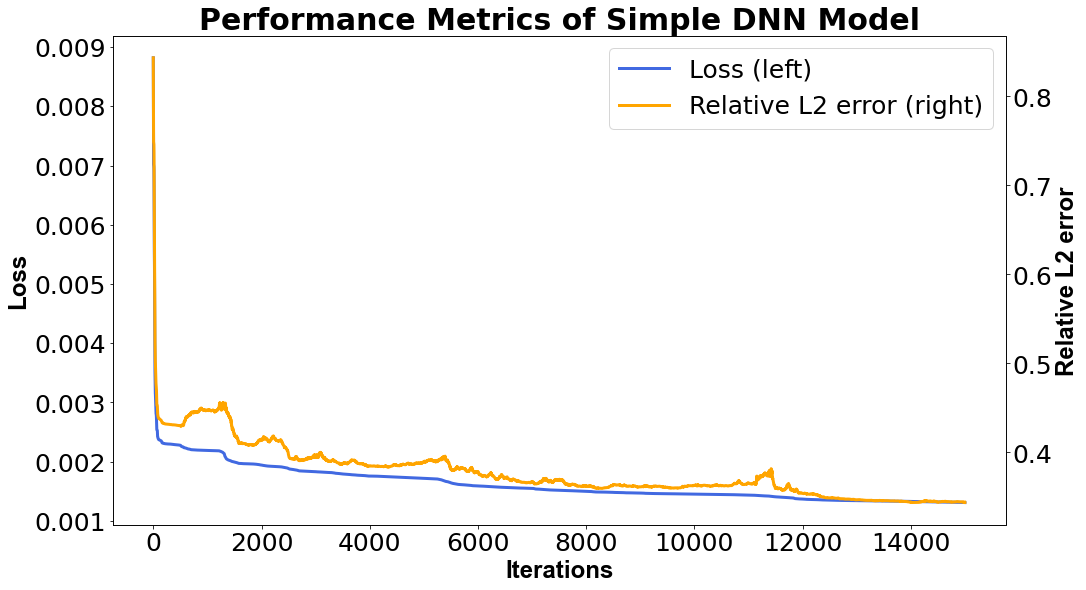

In [17]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Simple DNN Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [18]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.015319008273191673
MSE =  0.0016644229235054152
RMSE =  0.04079733966210806
L2 relative error = 0.38247914132919825
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

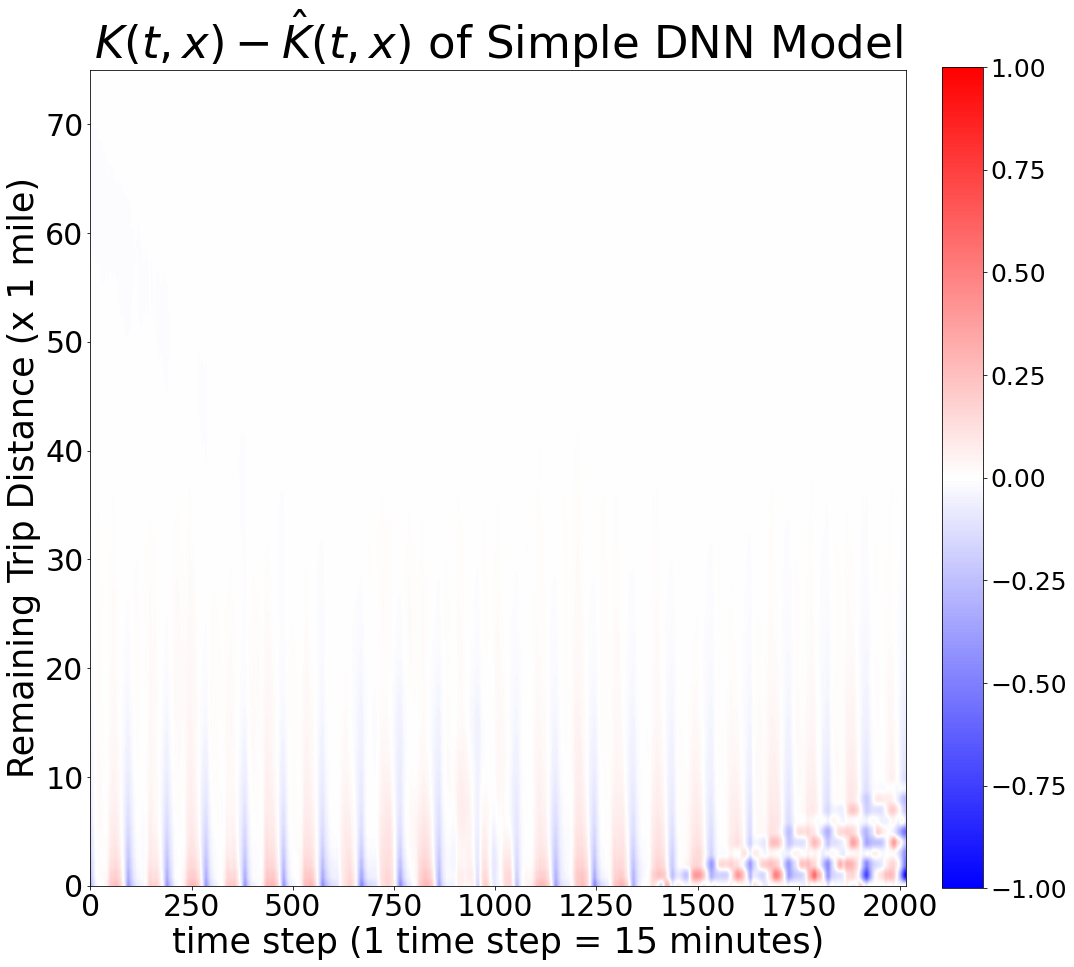

In [19]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

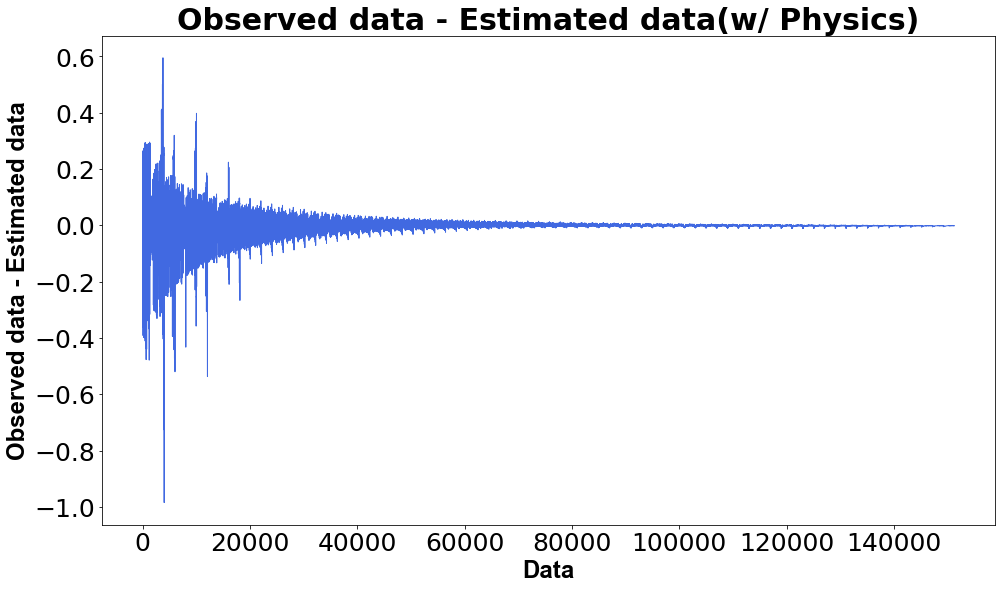

In [20]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)